# <center>数据预处理、描述性统计、评分卡、预测
<center> 李顺立 2019.6

----
## 数据预处理

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from matplotlib.font_manager import FontProperties
from wordcloud import WordCloud
from PIL import Image

import warnings
warnings.filterwarnings('ignore')  #不显示警告

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
import statsmodels.api as sm

##处理数据不平衡
from imblearn.over_sampling import SMOTE
##VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

##IV值、评分卡
import woe
import woe.feature_process as fp
import woe.eval as eval
from sklearn.metrics import confusion_matrix
import itertools

plt.rc("font",family="Arial Unicode MS", size="14")  #解决中文乱码问题
plt.rcParams['figure.figsize'] = (10, 8)  #设定图片参数
font1 = FontProperties(fname = '/System/Library/Fonts/PingFang.ttc')  #‘字体1’

In [418]:
df1 = pd.read_csv('LoanStats3_a.csv')
df2 = pd.read_csv('LoanStats3_b.csv')
df3 = pd.read_csv('LoanStats3_c.csv')
df4 = pd.read_csv('LoanStats3_d.csv')
df = pd.concat([df1, df2, df3, df4], ignore_index=False) #将4个文件放在一起
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,0.1065,162.87,B,B2,...,0.00,0.00,0,15-Jan,171.62,NaN,15-Jan,0.0,NaN,1.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,0.1527,59.83,C,C4,...,0.00,117.08,1.11,13-Apr,119.66,NaN,13-Sep,0.0,NaN,1.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,0.1596,84.33,C,C5,...,0.00,0.00,0,14-Jun,649.91,NaN,15-Apr,0.0,NaN,1.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,0.1349,339.31,C,C1,...,16.97,0.00,0,15-Jan,357.48,NaN,15-Jan,0.0,NaN,1.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,0.1269,67.79,B,B5,...,0.00,0.00,0,15-Apr,67.79,15-May,15-Apr,0.0,NaN,1.0


In [3]:
df.loan_status.value_counts()

Current                                                        396924
Fully Paid                                                     114825
Charged Off                                                     24661
Late (31-120 days)                                               6189
In Grace Period                                                  2967
Does not meet the credit policy.  Status:Fully Paid              1923
Late (16-30 days)                                                1246
Default                                                           841
Does not meet the credit policy.  Status:Charged Off              756
Issued                                                            162
Does not meet the credit policy.  Status:Current                   64
Does not meet the credit policy.  Status:Late (31-120 days)         3
Does not meet the credit policy.  Status:Default                    2
Does not meet the credit policy.  Status:In Grace Period            1
Name: loan_status, d

In [419]:
# #查看Object类型数据的缺失情况
# df.select_dtypes(include=['O']).describe()\
# .T.assign(missing = data_loan_a.apply(lambda x : (1 - x.count() /len(x)))).sort_values(by = 'missing',ascending = False)

#查看float64类型数据的缺失情况
# data_loan_a.select_dtypes(include=['float64']).describe()\
# .T.assign(missing = data_loan_a.apply(lambda x : (1 - x.count() /len(x)))).sort_values(by = 'missing',ascending = False)

##缺失比例大于50%直接去掉该特征

missing_dict = pd.DataFrame({'features' : df.columns.values, 'missing_rate' : [df[i].isnull().sum()*1.0/df.shape[0] for i in df.columns]})
missing_dict.sort_values(by = 'missing_rate', ascending = False)[:10].style.bar()   #前十缺失比例

,features,missing_rate
29,mths_since_last_record,0.859716
50,mths_since_last_major_derog,0.776115
19,desc,0.771152
28,mths_since_last_delinq,0.528939
47,next_pymnt_d,0.253375
10,emp_title,0.0585761
11,emp_length,0.0466033
45,last_pymnt_d,0.00200696
33,revol_util,0.000711973
49,collections_12_mths_ex_med,0.000299682


In [420]:
data_missing = missing_dict.sort_values(by = 'missing_rate', ascending=False)
data_missing[:10]

,features,missing_rate
29,mths_since_last_record,0.859716
50,mths_since_last_major_derog,0.776115
19,desc,0.771152
28,mths_since_last_delinq,0.528939
47,next_pymnt_d,0.253375
10,emp_title,0.058576
11,emp_length,0.046603
45,last_pymnt_d,0.002007
33,revol_util,0.000712
49,collections_12_mths_ex_med,0.000300


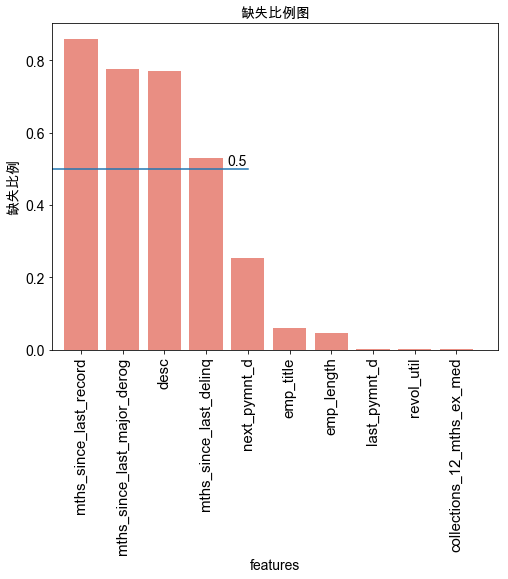

In [421]:
plt.figure(figsize=(8,6))


sns.barplot(data_missing.features[:10], data_missing.missing_rate[:10] , palette = ['salmon'])
plt.plot([-0.7,4], [0.5, 0.5])
plt.text(3.5, 0.51, '0.5', size= 14)

plt.title('缺失比例图', size = 14)
plt.xticks(rotation = 90, size = 14)
plt.xlabel('features', size = 14)
plt.ylabel('缺失比例', size = 14)
plt.xticks(size = 15)
plt.xlim(-0.7,10)

plt.savefig('./图片/缺失比例图.png', dpi = 500, bbox_inches = 'tight')
plt.show()
plt.close()


In [5]:
# #缺失值处理1，按照25%的阈值处理，缺失超过25%的列直接删除
# data_loan_a.dropna(
#     axis=1, thresh=int(0.75 * len(data_loan_a)),
#     inplace=True)

# #查看处理效果
# data_loan_a.describe().T.assign(
#     missing_pct=data_loan_a.apply(
#         lambda x: (1 - x.count() / len(x)))).sort_values(
#             by='missing_pct', ascending=False)

#留下的变量
col_name_leave =  [name for name in df.columns if name not in list(missing_dict[missing_dict['missing_rate'] > 0.5].features)]
print('原有变量：%s个'%(df.shape[1]))
print('留下的变量：%s个'%(len(col_name_leave)))

##去掉对建模没有意义的变量
name_out = ['id', 'member_id', 'installment', 'url', 'title', 'zip_code',
              'earliest_cr_line', 'out_prncp_inv', 'last_pymnt_d', 
              'next_pymnt_d', 'last_credit_pull_d', 'delinq_2yrs']

col_name_leave = [name for name in col_name_leave if name not in name_out]
print('原有变量：%s个'%(df.shape[1]))
print('留下的变量：%s个'%(len(col_name_leave)))

原有变量：52个
留下的变量：48个
原有变量：52个
留下的变量：36个


----
### 共36个变量
+ 各变量意义

|变量名|意义|缺失值处理|
|---|---|---|
|loan_amnt|申请贷款金额|均值|
|funded_amnt|该时间点承诺的贷款总额|均值|
|funded_amnt_inv|投资者为该笔贷款承诺的总金额|均值|
|term|时限|就近|
|int_rate|贷款利率|均值|
|grade|评价等级|就近|
|sub_grade|子等级|就近|
|emp_title|工作名称|就近|
|emp_length|工作年限|就近|
|home_ownership|房屋状况|就近|
|annual_inc|年收入|均值|
|verification_status|认证状态|就近|
|issue_d|时间|就近|
|loan_status|当前贷款状态|就近|
|pymnt_plan|是否已为贷款制定付款计划|就近|
|purpose|用途|就近|
|addr_state|地点|就近|
|dti|债务收入比|均值|
|inq_last_6mths|过去六个月征信查询数|0|
|open_acc|借款人信用档案中的未结信用额度|均值|
|pub_rec|贬损公共记录的数量|0|
|revol_bal|信贷循环余额合计|就近|
|revol_util|循环额度利用率|就近|
|total_acc|信贷总额|均值|
|initial_list_status|最初状态|就近|
|out_prncp|未还本金|0|
|total_pymnt|迄今收到的款项总额|均值|
|last_pymnt_amnt|最后收到的总付款金额|均值|
|collections_12_mths_ex_med|12月内搜集的数量|0|
|policy_code|标签|0|
|total_pymnt_inv|收到的部分款项|均值|
|total_rec_prncp |迄今为止收到的本金|均值|
|total_rec_int|迄今为止收到的利息|均值|
|total_rec_late_fee|迄今为止收到的滞纳金|均值|
|recoveries|销账后总回收率|均值|
|collection_recovery_fee |销账后收取费用|就近|
 
            










In [177]:

##所选择的变量
col_names = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'pymnt_plan',
             'term', 'int_rate', 'grade', 'sub_grade', 'emp_title', 'emp_length', 
             'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
             'purpose', 'addr_state', 'dti', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 
             'out_prncp', 'last_pymnt_amnt',  'revol_bal', 'revol_util', 'initial_list_status', 
            'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
            'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'policy_code']

#均值填充的变量
col_mean = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
            'annual_inc', 'dti', 'open_acc', 'total_acc', 'last_pymnt_amnt', 
            'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 
            'total_rec_late_fee', 'recoveries']

#用就近的值填充的变量
col_fill_last = [ 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 
             'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'purpose', 
                 'addr_state', 'pymnt_plan', 'revol_bal', 'revol_util', 'initial_list_status', 'collection_recovery_fee']

#用0或1填充的变量
col_zero = ['inq_last_6mths', 'pub_rec', 'out_prncp', 'collections_12_mths_ex_med']
col_one = ['policy_code']


##预处理函数
def Missing_Value_Processing(data):
    data_loan_total = data[col_names]
    #均值填充
    for name in col_mean:
        name_mean = data_loan_total[name].mean()
        data_loan_total[name] = data_loan_total[name].fillna(name_mean)

    #就近值填充：
    for name in col_fill_last:
        data_loan_total[name] = data_loan_total[name].fillna(method='backfill')

    #0 值填充
    for name in col_zero:
        data_loan_total[name] = data_loan_total[name].fillna(0)

    #1值填充
    for name in col_one:
        data_loan_total[name] = data_loan_total[name].fillna(1)
        
    #删除有空值的行
    data_loan_total.dropna(axis=0, inplace=True)  
    
    return data_loan_total

In [180]:
data_process_1 = Missing_Value_Processing(df)

In [192]:
data_process_1.to_csv('LoanStats3_processing_2.csv', encoding='utf-8', index=False)

----
## <center>描述性统计
#### 贷款数据分析

In [2]:
data_load_processing = pd.read_csv('LoanStats3_processing.csv')

----
#### 贷款质量情况
+ 1.将逾期超过15天视为坏账

In [23]:
data_load_processing.loan_status.value_counts()

Current                                                        396922
Fully Paid                                                     114825
Charged Off                                                     24660
Late (31-120 days)                                               6189
In Grace Period                                                  2967
Does not meet the credit policy.  Status:Fully Paid              1923
Late (16-30 days)                                                1246
Default                                                           841
Does not meet the credit policy.  Status:Charged Off              756
Issued                                                            162
Does not meet the credit policy.  Status:Current                   67
Does not meet the credit policy.  Status:Late (31-120 days)         3
Does not meet the credit policy.  Status:Default                    2
Does not meet the credit policy.  Status:In Grace Period            1
Name: loan_status, d

In [5]:
## 增加一列，坏账和正常账
good_loan = ['Current', 'Fully Paid','Does not meet the credit policy. Status:Fully Paid', 
             'Does not meet the credit policy.  Status:Current', 'Issued ']

def loan_condition(status):
    if status in good_loan:
        return  1#'good_loan'
    else:
        return  0#'bad_loan'


data_load_processing['loan_condition'] = data_load_processing.loan_status.apply(loan_condition)

In [6]:
data_process_1['loan_condition'] = data_process_1.loan_status.apply(loan_condition)  #增加一列，好或者坏

----
##### 贷款质量和贷款总额情况

In [8]:
plt.rc("font",family="Arial Unicode MS", size="14")  #解决中文乱码问题

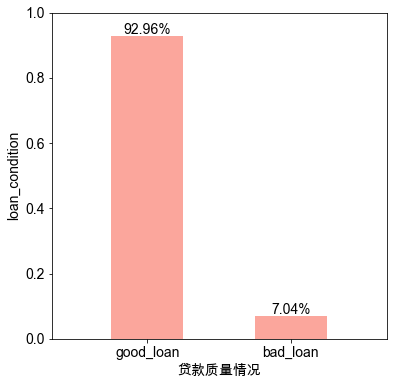

In [9]:
#贷款品质情况
fig, ax1 = plt.subplots(1, 1, figsize = (6, 6))

y = list(data_load_processing.loan_condition.value_counts()/len(data_load_processing))
plt.bar([0.7, 1], y, fc = 'salmon', width = 0.15, alpha = 0.7)

plt.xlim(0.5, 1.2)
plt.ylim(0, 1)

plt.text(0.7, y[0]+0.005, '92.96%', ha='center')
plt.text(1, y[1]+0.005, '7.04%', ha='center')

plt.xticks([0.7, 1], ['good_loan', 'bad_loan'])

plt.ylabel('loan_condition')
plt.xlabel('贷款质量情况')

#plt.savefig('./图片/贷款质量情况.png',  dpi = 500, bbox_inches='tight')

plt.show()
plt.close()
# plt.figure(figsize=(8,6))
# plt.plot(data_load_processing.issue_d, data_load_processing) data_load_processing.loan_condition.unique() 


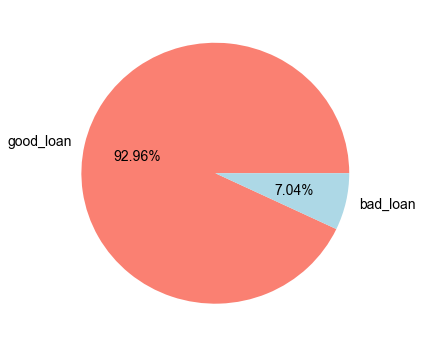

In [22]:
fig = plt.figure(figsize=(6,6))

y = list(data_load_processing.loan_condition.value_counts()/len(data_load_processing))

plt.pie(y, autopct='%.2f%%', labels= ['good_loan', 'bad_loan'], colors=['salmon', 'lightblue'])

plt.savefig('./图片/贷款情况饼图.png', dpi = 500, bbox_inches = 'tight')

plt.show()
plt.close()

In [11]:
y

[0.9296176284682617, 0.07038237153173836]

+ 可以看出，坏账仅有不到8%，但是实际上的金额确是比较惊人的。

----
##### 贷款金额按年查看

In [126]:
def year_transform(year):
    a = re.findall(r'\d+', year)[0]
    if len(a) == 2:
        return('20'+a)
    else:
        return('200'+a)
 ##转换年   
data_load_processing['issue_year'] = data_load_processing.issue_d.apply(year_transform)

In [127]:
data_load_processing.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,...,inq_last_6mths,open_acc,pub_rec,total_acc,out_prncp,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,loan_condition,issue_year
0,5000.0,5000.0,4975.0,36 months,0.1065,B,B2,Ryder,10+ years,RENT,...,1.0,3.0,0.0,9.0,0.00,171.62,0.0,1.0,good_loan,2011
1,2500.0,2500.0,2500.0,60 months,0.1527,C,C4,Ryder,< 1 year,RENT,...,5.0,3.0,0.0,4.0,0.00,119.66,0.0,1.0,bad_loan,2011
2,2400.0,2400.0,2400.0,36 months,0.1596,C,C5,AIR RESOURCES BOARD,10+ years,RENT,...,2.0,2.0,0.0,10.0,0.00,649.91,0.0,1.0,good_loan,2011
3,10000.0,10000.0,10000.0,36 months,0.1349,C,C1,AIR RESOURCES BOARD,10+ years,RENT,...,1.0,10.0,0.0,37.0,0.00,357.48,0.0,1.0,good_loan,2011
4,3000.0,3000.0,3000.0,60 months,0.1269,B,B5,University Medical Group,1 year,RENT,...,0.0,15.0,0.0,38.0,1277.33,67.79,0.0,1.0,good_loan,2011


In [129]:
data_load_processing.sort_values('issue_year', inplace=True, ascending=True)
data_load_processing.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,...,inq_last_6mths,open_acc,pub_rec,total_acc,out_prncp,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,loan_condition,issue_year
39676,8275.0,8275.0,625.0,36 months,0.0901,B,B2,SCE & G,10+ years,MORTGAGE,...,0.0,10.0,0.0,20.0,0.0,265.32,0.0,1.0,good_loan,2007
39738,6500.0,6500.0,225.0,36 months,0.1501,F,F1,Universal Advertising,9 years,MORTGAGE,...,0.0,11.0,0.0,28.0,0.0,225.37,0.0,1.0,bad_loan,2007
39737,2500.0,2500.0,825.0,36 months,0.0964,B,B4,AMZ Marketing,< 1 year,MORTGAGE,...,3.0,9.0,0.0,35.0,0.0,1.40,0.0,1.0,bad_loan,2007
39736,2500.0,2500.0,675.0,36 months,0.1280,D,D4,Nebraska Occupational Therapy,< 1 year,MORTGAGE,...,1.0,11.0,0.0,32.0,0.0,1.76,0.0,1.0,bad_loan,2007
39735,15450.0,15450.0,600.0,36 months,0.1122,C,C4,ARIN,2 years,MORTGAGE,...,3.0,13.0,1.0,29.0,0.0,1016.15,0.0,1.0,bad_loan,2007


In [3]:
data_load_processing.to_csv('LoanStats3_processing_1.csv', encoding='utf-8', index=False)

In [6]:
data_load_processing = pd.read_csv('LoanStats3_processing_1.csv')

In [8]:
plt.rc("font",family="Arial Unicode MS", size=14)  #解决中文乱码问题
plt.rcParams['figure.figsize'] = (10, 8)  #设定图片参数

+ 金额

In [256]:
##统计贷款额的坏账率

names = list(range(2007, 2016))  #从大到小排序
bad_rate_dict = {}
for name in names:
    name_df = data_load_processing[data_load_processing['issue_year'] == name]
    bad_rate_1 = name_df['loan_amnt'][name_df['loan_condition'] == 'bad_loan'].sum()/name_df['loan_amnt'].sum()
    bad_rate_dict[str(name)] = bad_rate_1


In [257]:
bad_rate_dict

{'2007': 0.6522584242010256,
 '2008': 0.44833860103933615,
 '2009': 0.22653180109092835,
 '2010': 0.19132943207044673,
 '2011': 0.15700225262298884,
 '2012': 0.16044662694179368,
 '2013': 0.09886197679024425,
 '2014': 0.038567394322985414,
 '2015': 0.007448270917037253}

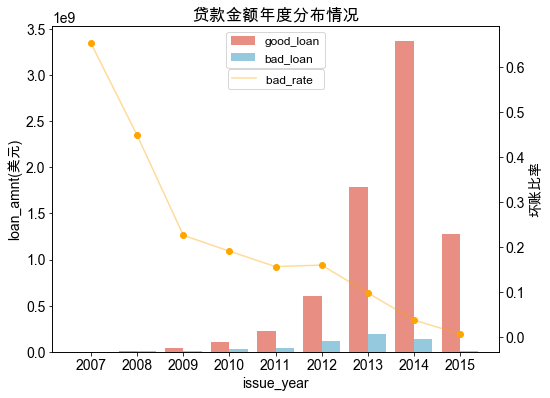

In [294]:
fig= plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

f1 = sns.barplot(
    x='issue_year',
    y='loan_amnt',
    data=data_load_processing,
    ci = 0,  #允许误差
    hue='loan_condition',
    estimator = np.sum,
    #estimator=lambda x: len(x) / len(data_load_processing) * 100,  #计算比例
    ax=ax1, palette = ['salmon', 'skyblue'])   #palette设置颜色

plt.ylabel('loan_amnt(美元)')
plt.title('贷款金额年度分布情况')
ax1.legend(loc = 'upper center', fontsize =12)

###移除该图示例
#ax1.legend_.remove()

##画出bad的比率
ax2 = ax1.twinx()
x = list(bad_rate_dict.keys())
y = list(bad_rate_dict.values())


f2 = ax2.plot(x, y, c = 'orange', alpha = 0.4)
ax2.scatter(x, y, c = 'orange')
ax2.set_ylabel('坏账比率')
ax2.legend(['bad_rate  '],  bbox_to_anchor=(0.6227, 0.885), bbox_transform=ax1.transAxes, fontsize = 12)

#fig.legend(['good_loan', 'bad_loan', 'bad_rate'], bbox_to_anchor=(0.6, 1), bbox_transform=ax1.transAxes, fontsize = 12)



plt.savefig('./图片/贷款金额年度分布情况.png',  dpi = 500, bbox_inches='tight')
plt.show()
plt.close()

+ 2011年后，贷款总额每年都在飙升, 2015年是由于数据仅有前三个月的数据，所以较小

----
##### 贷款人数量

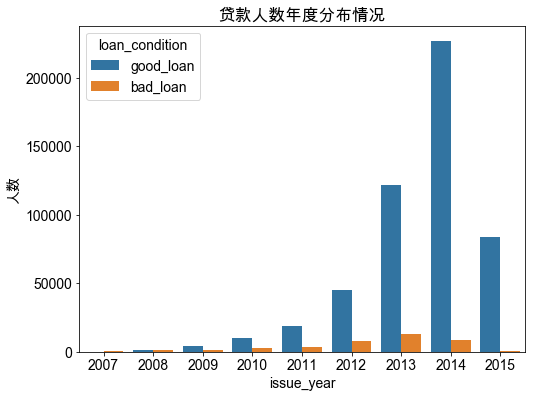

In [77]:
###j计数方式1
fig, ax2 = plt.subplots(1, 1, figsize=(8,6))
sns.barplot(
    x='issue_year',
    y='loan_amnt',
    data=data_load_processing,
    hue='loan_condition',
    estimator=lambda x: len(x),  #计算比例
    ax=ax2)#, palette = ['salmon', 'skyblue'])   #palette设置颜色
plt.ylabel('人数')
plt.title('贷款人数年度分布情况')
#plt.savefig('./图片/贷款金额年度分布情况.png')
plt.show()
plt.close()

In [302]:
x, y = bad_rate('issue_year')
data = pd.DataFrame()
data['issue_year'] = x
data['bad_rate'] = y
data = data.sort_values(by = 'issue_year')

In [303]:
data

,issue_year,bad_rate
8,2007,0.658375
7,2008,0.450481
6,2009,0.219655
5,2010,0.193062
4,2011,0.145665
3,2012,0.150792
1,2013,0.096270
0,2014,0.037831
2,2015,0.007072


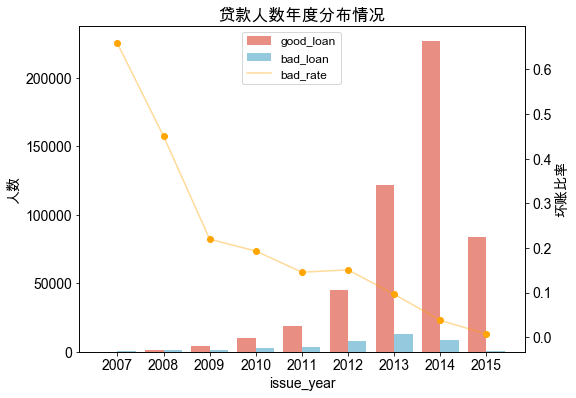

In [314]:
##计数方式2
fig= plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

sns.countplot(
    x='issue_year',
    data=data_load_processing,
    hue='loan_condition',
    #estimator=lambda x: len(x),  #计算比例
    ax=ax1, palette = ['salmon', 'skyblue'])   #palette设置颜色

plt.ylabel('人数')
plt.title('贷款人数年度分布情况')
#ax1.legend(loc = 'upper center', fontsize =12)

###移除该图示例
ax1.legend_.remove()

##bad_rate
ax2 = ax1.twinx()




x = list(range(9))

y = data.bad_rate


f2 = ax2.plot(x, y, c = 'orange', alpha = 0.4)
ax2.scatter(x, y, c = 'orange')
ax2.set_ylabel('坏账比率')
#ax2.legend(['bad_rate  '],  bbox_to_anchor=(0.6227, 0.885), bbox_transform=ax1.transAxes, fontsize = 12)

fig.legend(['good_loan', 'bad_loan', 'bad_rate'], bbox_to_anchor=(0.6, 1), bbox_transform=ax1.transAxes, fontsize = 12)


plt.savefig('./图片/贷款人数年度分布情况.png',  dpi = 500, bbox_inches='tight')
plt.show()
plt.close()

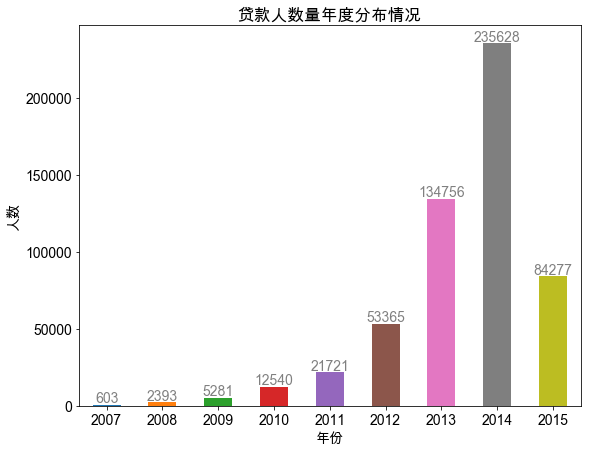

In [291]:
##总贷款人数
fig, ax3= plt.subplots(1, 1, figsize=(9, 7))

year_dist = data_load_processing.groupby(['issue_year']).size()  #按年计数

year_dist.plot(kind='bar', ax=ax3)
ax3.set_title('贷款人数量年度分布情况')
ax3.set_ylabel('人数')
ax3.set_xlabel('年份')

plt.xticks(rotation = 0)
x = range(9)
y = list(year_dist)

for x,y in zip(x,y):
    plt.text(x, y+1500, str(y), ha = 'center', color = 'gray')
    
    
plt.savefig('./图片/贷款人数量年度分布情况.png')
plt.show()
plt.close()

----
#### 客户画像

+  地区

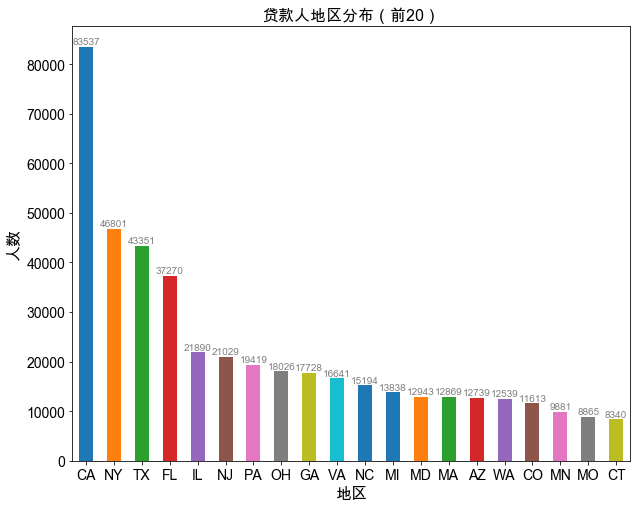

In [86]:
### 地区
fig,ax4 = plt.subplots(1,1,figsize = (10,8))
data_load_processing.addr_state.value_counts()[:20].plot(kind = 'bar', ax = ax4)

plt.xlabel('地区', size=16)
plt.ylabel('人数', size = 16)
plt.title('贷款人地区分布（前20）', size =16)
plt.xticks(rotation = 0)

y = list(data_load_processing.addr_state.value_counts()[:20])
x = range(len(y))


for x,y in zip(x,y):
    plt.text(x, y+500, str(y), ha = 'center', color = 'gray', size = 10)

#plt.savefig('./图片/贷款人地区分布_20.png')
plt.show()
plt.close()

In [316]:
x, y= bad_rate(col_name='addr_state')


[0.07589451380825263,
 0.07636588961774321,
 0.05928352287144472,
 0.08154011269117252,
 0.06459570580173596,
 0.07917637548147796,
 0.07029198207940676,
 0.06701431265949184,
 0.06797157039711191,
 0.07217114356108408]

In [319]:
x = x[:10]
y = y[:10]

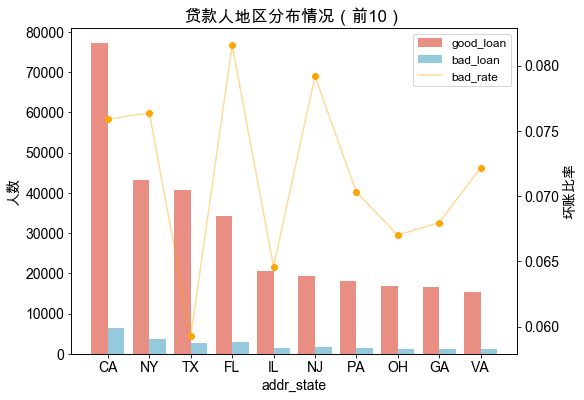

In [327]:
fig= plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)


sns.countplot(
    x='addr_state',
    data=data_load_processing,
    hue='loan_condition',
    order = x,

    ax=ax1, palette = ['salmon', 'skyblue'])   #palette设置颜色

plt.ylabel('人数')
plt.title('贷款人地区分布情况（前10）')
###移除该图示例
ax1.legend_.remove()

##bad_rate
ax2 = ax1.twinx()


f2 = ax2.plot(x, y, c = 'orange', alpha = 0.4)
ax2.scatter(x, y, c = 'orange')
ax2.set_ylabel('坏账比率')
#ax2.legend(['bad_rate  '],  bbox_to_anchor=(0.6227, 0.885), bbox_transform=ax1.transAxes, fontsize = 12)

fig.legend(['good_loan', 'bad_loan', 'bad_rate'], bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, fontsize = 12)





plt.savefig('./图片/贷款人地区分布情况（前10）.png', dpi = 500, bbox_inches='tight')
plt.show()
plt.close()

---
+ 职业

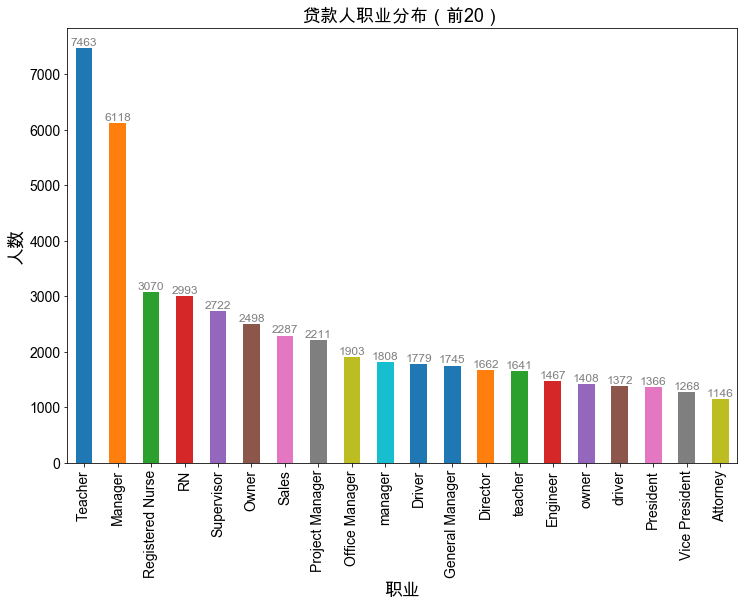

In [299]:
###职业
fig,ax5 = plt.subplots(1,1,figsize = (12,8))
data_load_processing.emp_title.value_counts()[:20].plot(kind = 'bar', ax = ax5)

plt.xlabel('职业', size=18)
plt.ylabel('人数', size = 18)
plt.title('贷款人职业分布（前20）', size =18)


y = list(data_load_processing.emp_title.value_counts()[:20])
x = range(len(y))


for x,y in zip(x,y):
    plt.text(x, y+50, str(y), ha = 'center', color = 'gray', size = 12)

#plt.savefig('./图片/贷款人职业分布_20.png')
plt.show()
plt.close()


In [333]:
##统计贷款者职业数量为前100的坏账率
bad_rate_dict = {}
for name in emp_name:
    name_df = data_load_processing[data_load_processing['emp_title'] == name]
    bad_rate = name_df[name_df['loan_condition'] == 'bad_loan'].shape[0]/len(name_df)
    bad_rate_dict[name] = bad_rate

#bad_rate_list_20 = sorted(bad_rate_dict.items(), key = lambda x :x[1], reverse=True)[:20]

# bad_rate_list_20_name = [name[0] for name in bad_rate_list]
# bad_rate_list_20_value = [name[1] for name in bad_rate_list]

In [336]:
bad_rate_dict
x = list(bad_rate_dict.keys())

{'Teacher': 0.02934476751976417,
 'Manager': 0.039718862373324615,
 'Registered Nurse': 0.03452768729641694,
 'RN': 0.033077180086869364,
 'Supervisor': 0.04041146216017634,
 'Owner': 0.02722177742193755,
 'Sales': 0.04241364232619152,
 'Project Manager': 0.029850746268656716,
 'Office Manager': 0.029427220178665267,
 'manager': 0.05752212389380531}

In [339]:
x = list(bad_rate_dict.keys())
y = list(bad_rate_dict.values())

[0.02934476751976417,
 0.039718862373324615,
 0.03452768729641694,
 0.033077180086869364,
 0.04041146216017634,
 0.02722177742193755,
 0.04241364232619152,
 0.029850746268656716,
 0.029427220178665267,
 0.05752212389380531]

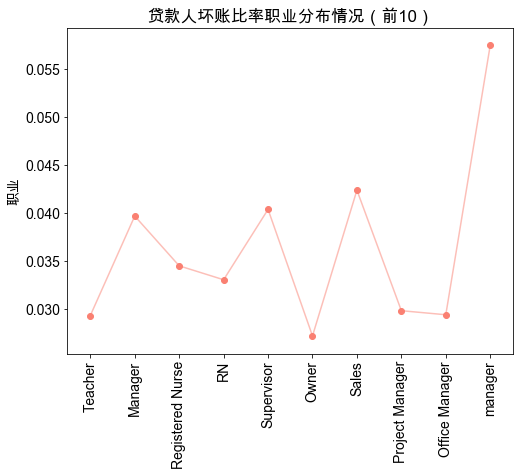

In [340]:
##职业坏账比率

fig, ax2 = plt.subplots(1, 1, figsize=(8,6))
# sns.barplot(
#     x=bad_rate_list_20_name,
#     y = bad_rate_list_20_value,
    
#     ax=ax2, palette = ['salmon'])   #palette设置颜色

plt.plot(x, y, color = 'salmon', alpha = 0.5)
plt.scatter(x, y, color = 'salmon')
plt.ylabel('职业')
plt.title('贷款人坏账比率职业分布情况（前10）')
plt.xticks(rotation = 90)
plt.savefig('./图片/贷款人坏账比率职业分布情况（前10）.png', dpi = 500, bbox_inches='tight')

plt.show()
plt.close()

In [330]:
emp_name = list(data_loan_processing.emp_title.value_counts().to_dict().keys())[:10]
emp_name

['Teacher',
 'Manager',
 'Registered Nurse',
 'RN',
 'Supervisor',
 'Owner',
 'Sales',
 'Project Manager',
 'Office Manager',
 'manager']

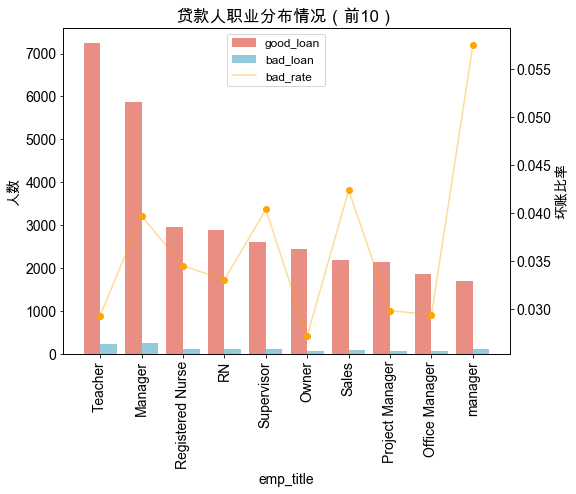

In [345]:
fig= plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

sns.countplot(
    x='emp_title',
    data=data_load_processing,
    hue='loan_condition',
    order =emp_name,
    ax=ax1, palette = ['salmon', 'skyblue'])   #palette设置颜色

plt.xticks(rotation = 90)
plt.ylabel('人数')
plt.title('贷款人职业分布情况（前10）')
###移除该图示例
ax1.legend_.remove()

##bad_rate
ax2 = ax1.twinx()


f2 = ax2.plot(x, y, c = 'orange', alpha = 0.4)
ax2.scatter(x, y, c = 'orange')
ax2.set_ylabel('坏账比率')
#ax2.legend(['bad_rate  '],  bbox_to_anchor=(0.6227, 0.885), bbox_transform=ax1.transAxes, fontsize = 12)

fig.legend(['good_loan', 'bad_loan', 'bad_rate'], bbox_to_anchor=(0.6, 1), bbox_transform=ax1.transAxes, fontsize = 12)





plt.savefig('./图片/贷款人职业分布情况（前10）.png', dpi = 500, bbox_inches='tight')
plt.show()
plt.close()

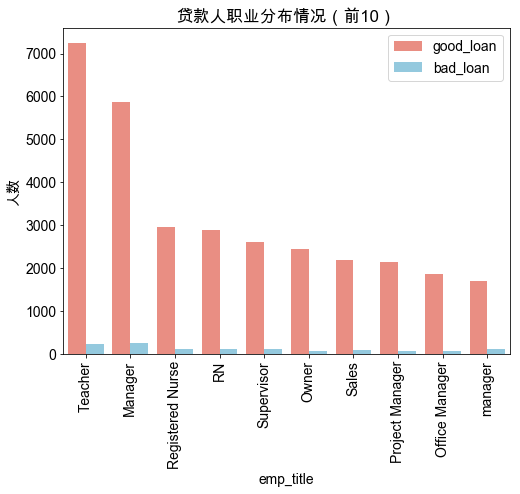

In [217]:
fig, ax2 = plt.subplots(1, 1, figsize=(8,6))
sns.countplot(
    x='emp_title',
    data=data_load_processing,
    hue='loan_condition',
    order =emp_name,
    ax=ax2, palette = ['salmon', 'skyblue'])   #palette设置颜色
plt.ylabel('人数')
plt.title('贷款人职业分布情况（前10）')
plt.xticks(rotation = 90)
plt.legend()
plt.savefig('./图片/贷款人职业分布情况（前10）.png',  dpi = 500, bbox_inches='tight')

plt.show()
plt.close()

---
+ 工作年限

+ 坏账函数

In [352]:
##贷款者工作年限坏账率
def bad_rate(col_name, data = data_load_processing):
    
    """
    计算离散变量的坏账率;
    返回该变量的unique值和坏账率.
    
    """
    names = list(data[col_name].value_counts().to_dict().keys())
    bad_rate_dict = {}
    for name in names:
        name_df = data[data[col_name] == name]
        bad_rate = name_df[name_df['loan_condition'] == 'bad_loan'].shape[0]/len(name_df)
        bad_rate_dict[name] = bad_rate
    return names, list(bad_rate_dict.values())
        


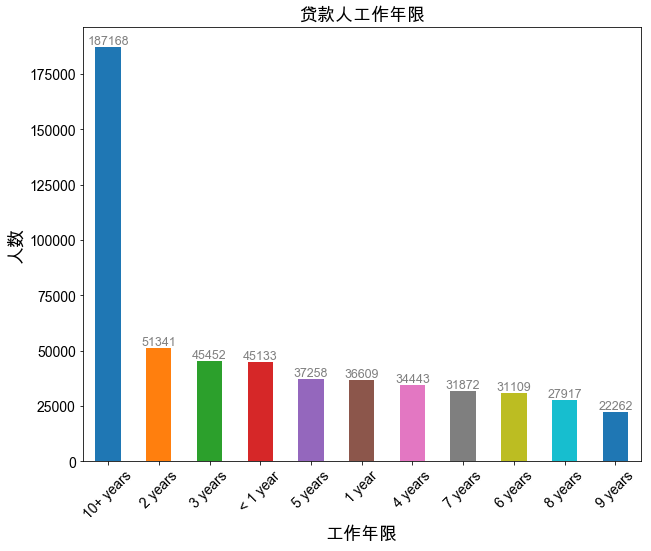

In [211]:
## 工作年限
fig,ax6 = plt.subplots(1,1,figsize = (10,8))
data_load_processing.emp_length.value_counts().plot(kind = 'bar')

plt.xlabel('工作年限', size=18)
plt.ylabel('人数', size = 18)
plt.title('贷款人工作年限', size =18)

y = list(data_load_processing.emp_length.value_counts())
x = range(len(y))


for x,y in zip(x,y):
    plt.text(x, y+1200, str(y), ha = 'center', color = 'gray', size = 12.5)
    
plt.xticks(rotation = 45)

#plt.savefig('./图片/贷款人工作年限.png',  dpi = 500, bbox_inches='tight')
plt.show()
plt.close()



In [269]:
name_emp_lenth = list(data_load_processing.emp_length.value_counts().to_dict().keys())

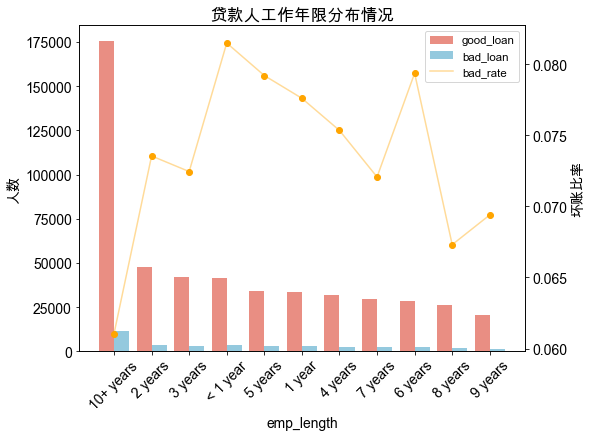

In [232]:
##贷款者工作年限坏账率


fig= plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)


f1 = sns.countplot(
    x='emp_length',
    data=data_load_processing,
    hue='loan_condition',
    order = name_emp_lenth,
    ax=ax1, palette = ['salmon', 'skyblue'])   #palette设置颜色

plt.ylabel('人数')
plt.title('贷款人工作年限分布情况')
plt.xticks(rotation = 45)

###移除该图示例
ax1.legend_.remove()

##画出bad的比率
ax2 = ax1.twinx()
x, y = bad_rate(col_name='emp_length')

f2 = ax2.plot(x, y, c = 'orange', alpha = 0.4)
ax2.scatter(x, y, c = 'orange')
ax2.set_ylabel('坏账比率')

#合并示例
fig.legend(['good_loan', 'bad_loan', 'bad_rate'],  bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, fontsize = 11.5)

#plt.savefig('./图片/贷款人工作年限分布情况.png',  dpi = 500, bbox_inches='tight')   #可以剪除当前图表周围的空白部分

plt.show()
plt.close()

---
+ 收入

In [351]:
data_load_processing.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,...,open_acc,pub_rec,total_acc,out_prncp,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,loan_condition,issue_year,inc_grade
0,8275.0,8275.0,625.0,36 months,0.0901,B,B2,SCE & G,10+ years,MORTGAGE,...,10.0,0.0,20.0,0.0,265.32,0.0,1.0,good_loan,2007,high
1,6500.0,6500.0,225.0,36 months,0.1501,F,F1,Universal Advertising,9 years,MORTGAGE,...,11.0,0.0,28.0,0.0,225.37,0.0,1.0,bad_loan,2007,high
2,2500.0,2500.0,825.0,36 months,0.0964,B,B4,AMZ Marketing,< 1 year,MORTGAGE,...,9.0,0.0,35.0,0.0,1.40,0.0,1.0,bad_loan,2007,high
3,2500.0,2500.0,675.0,36 months,0.1280,D,D4,Nebraska Occupational Therapy,< 1 year,MORTGAGE,...,11.0,0.0,32.0,0.0,1.76,0.0,1.0,bad_loan,2007,mid
4,15450.0,15450.0,600.0,36 months,0.1122,C,C4,ARIN,2 years,MORTGAGE,...,13.0,1.0,29.0,0.0,1016.15,0.0,1.0,bad_loan,2007,mid


In [350]:
### 用户收入

def inc_strata(income):
    if income <= 30000:  #低于3w为低收入
        return 'low'
    elif income > 30000 and income <= 60000:
        return 'mid'
    else:
        return 'high'

data_load_processing['inc_grade'] = data_load_processing.annual_inc.apply(inc_strata)#数据转化

In [353]:
bad_rate('inc_grade')

(['high', 'mid', 'low'],
 [0.05829105808897313, 0.0803791861348827, 0.100667718829671])

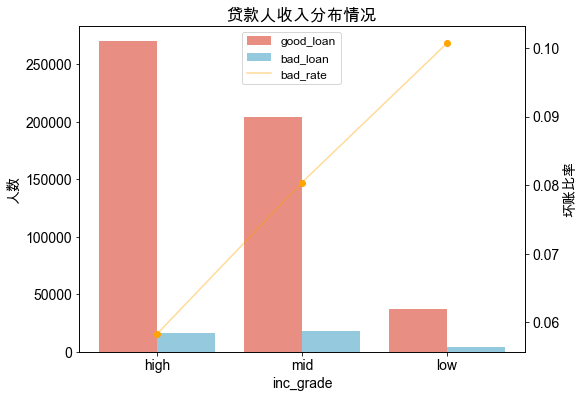

In [355]:
fig= plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

sns.countplot(
    x='inc_grade',
    data=data_load_processing,
    hue='loan_condition',
    order =['high', 'mid', 'low'],
    ax=ax1, palette = ['salmon', 'skyblue'])   #palette设置颜色

#plt.xticks(rotation = 90)
plt.ylabel('人数')
plt.title('贷款人收入分布情况')
###移除该图示例
ax1.legend_.remove()

##bad_rate
ax2 = ax1.twinx()

x, y = bad_rate('inc_grade')

f2 = ax2.plot(x, y, c = 'orange', alpha = 0.4)
ax2.scatter(x, y, c = 'orange')
ax2.set_ylabel('坏账比率')
#ax2.legend(['bad_rate  '],  bbox_to_anchor=(0.6227, 0.885), bbox_transform=ax1.transAxes, fontsize = 12)

fig.legend(['good_loan', 'bad_loan', 'bad_rate'], bbox_to_anchor=(0.6, 1), bbox_transform=ax1.transAxes, fontsize = 12)





plt.savefig('./图片/贷款人收入分布情况.png', dpi = 500, bbox_inches='tight')
plt.show()
plt.close()

---
+ 目的

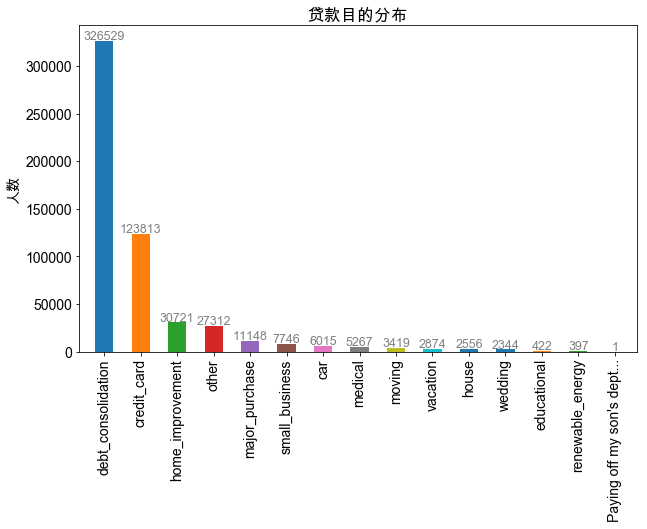

In [366]:
###贷款目的分布
plt.figure(figsize=(10,6))

data = data_load_processing.purpose.value_counts()
data.plot(kind='bar')  # color = ['', 'blue']

y = list(data)
x = range(len(y))
for x,y in zip(x,y):
    plt.text(x, y+1500, str(y), ha = 'center', color = 'gray', size = 12.5)

plt.xlim(-.7, 14.6)  
plt.xticks(rotation = 90)

#plt.xlabel('用途')
plt.ylabel('人数')
plt.title('贷款目的分布')

plt.show()
plt.close()

---
+ 住房类型

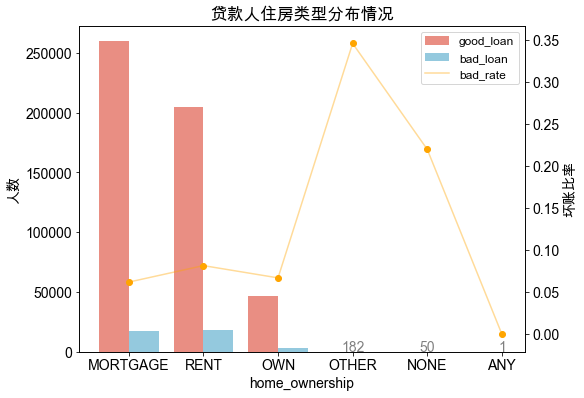

In [368]:
fig= plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

sns.countplot(
    x='home_ownership',
    data=data_load_processing,
    hue='loan_condition',
#    order =['high', 'mid', 'low'],
    ax=ax1, palette = ['salmon', 'skyblue'])   #palette设置颜色

data = data_load_processing.home_ownership.value_counts()
y = list(data)[3:]
x = range(3, 6)
for x1,y1 in zip(x,y):
    plt.text(x1, y1+100, str(y1), ha = 'center', color = 'gray', size = 14)



#plt.xticks(rotation = 90)
plt.ylabel('人数')
plt.title('贷款人住房类型分布情况')
###移除该图示例
ax1.legend_.remove()

##bad_rate
ax2 = ax1.twinx()

x0, y0 = bad_rate('home_ownership')

f2 = ax2.plot(x0, y0, c = 'orange', alpha = 0.4)
ax2.scatter(x0, y0, c = 'orange')
ax2.set_ylabel('坏账比率')
#ax2.legend(['bad_rate  '],  bbox_to_anchor=(0.6227, 0.885), bbox_transform=ax1.transAxes, fontsize = 12)

fig.legend(['good_loan', 'bad_loan', 'bad_rate'], bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, fontsize = 12)





plt.savefig('./图片/贷款人住房类型分布情况.png', dpi = 500, bbox_inches='tight')
plt.show()
plt.close()

---
+ 贬损公共记录的次数

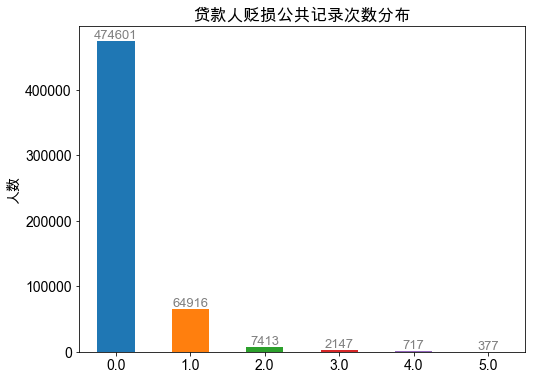

In [384]:
##贬损公共记录的次数
plt.figure(figsize=(8,6))

data = data_load_processing.pub_rec.value_counts()[:5]
data.plot(kind='bar')  # color = ['', 'blue']

y = list(data)
x = range(len(y))
for x,y in zip(x,y):
    plt.text(x, y+3500, str(y), ha = 'center', color = 'gray', size = 13)

#plt.ylim(0, 300000)  
plt.xticks(rotation = 0)

#plt.xlabel('用途')
plt.ylabel('人数')
plt.title('贷款人贬损公共记录次数分布')

#plt.savefig('./图片/贷款人贬损公共记录的次数.png')
plt.show()
plt.close()


----
####  业务分析
+ 贷款量明细

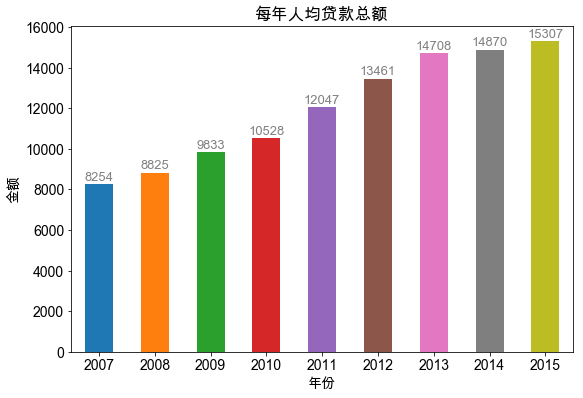

In [400]:
## 业务分析
#业务分析1-1 贷款量明细：每年人均贷款总额，年均贷款总金额
plt.figure(figsize=(9, 6))

data = data_load_processing.groupby(['issue_year'])['loan_amnt'].mean()
data.plot(kind='bar')

y = list(data)
x = range(len(y))
for x,y in zip(x,y):
    plt.text(x, y+200, str(int(y)), ha = 'center', color = 'gray', size = 13)


plt.xticks(rotation = 0)
plt.xlabel('年份')
plt.ylabel('金额')
plt.title('每年人均贷款总额')

plt.savefig('./图片/每年人均贷款总额.png')
plt.show()
plt.close()

---
+ 年均贷款总金额

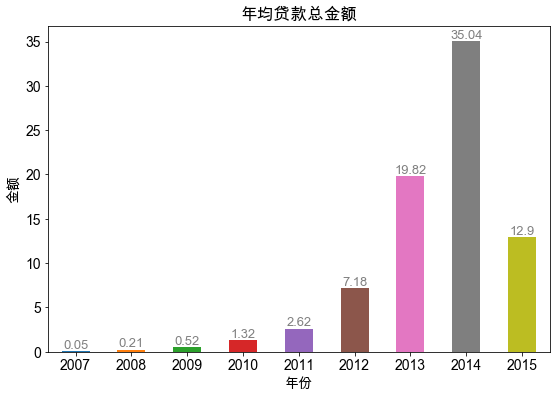

In [418]:
##年均贷款总金额（亿美元）
plt.figure(figsize=(9, 6))

data = data_load_processing.groupby(['issue_year'])['loan_amnt'].sum()/1e8
data.plot(kind='bar')

y = list(data)
x = range(len(y))
for x,y in zip(x,y):
    plt.text(x, y+0.3, str(float('%0.2f'%(y))), ha = 'center', color = 'gray', size = 13)


plt.xticks(rotation = 0)
plt.xlabel('年份')
plt.ylabel('金额')
plt.title('年均贷款总金额')

#plt.savefig('./图片/年均贷款总金额.png')
plt.show()
plt.close()

---
+ 平均贷款利率与信用等级关系

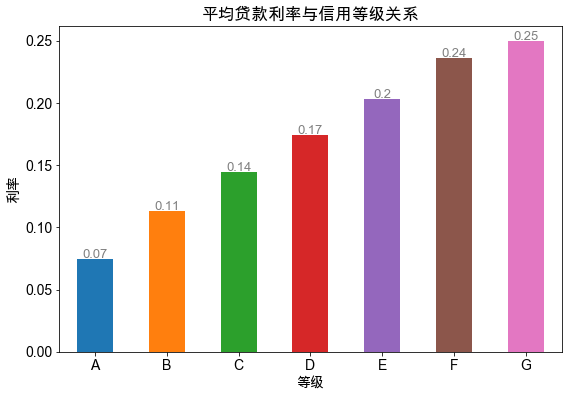

In [426]:
### 平均贷款利率与信用等级关系

plt.figure(figsize=(9, 6))

data = data_load_processing.groupby(['grade'])['int_rate'].mean()
data.plot(kind='bar')

y = list(data)
x = range(len(y))
for x,y in zip(x,y):
    plt.text(x, y+0.001, str(float('%0.2f'%(y))), ha = 'center', color = 'gray', size = 13)


plt.xticks(rotation = 0)
plt.xlabel('等级')
plt.ylabel('利率')
plt.title('平均贷款利率与信用等级关系')

#plt.savefig('./图片/平均贷款利率与信用等级关系.png')
plt.show()
plt.close()





---
+ 贷款情况与信用等级的关系

In [374]:
bad_rate('grade')

(['B', 'C', 'D', 'A', 'E', 'F', 'G'],
 [0.05299896425096513,
  0.07058453339760455,
  0.09741227924853385,
  0.02649776020197281,
  0.12207088288204097,
  0.1686651732771116,
  0.20436250324591015])

In [380]:
x, y =bad_rate('grade')
dd = pd.DataFrame()
dd['x'] = x
dd['y'] = y
dd.sort_values(by = 'x', inplace=True)

In [382]:
dd

,x,y
3,A,0.026498
0,B,0.052999
1,C,0.070585
2,D,0.097412
4,E,0.122071
5,F,0.168665
6,G,0.204363


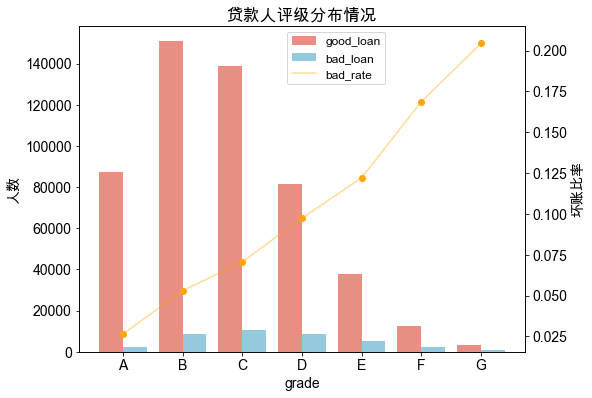

In [383]:
fig= plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

sns.countplot(
    x='grade',
    data=data_load_processing,
    hue='loan_condition',
    order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
    ax=ax1, palette = ['salmon', 'skyblue'])   #palette设置颜色


#plt.xticks(rotation = 90)
plt.ylabel('人数')
plt.title('贷款人评级分布情况')
###移除该图示例
ax1.legend_.remove()

##bad_rate
ax2 = ax1.twinx()

x0 =  dd['x']
y0 = dd['y']

f2 = ax2.plot(x0, y0, c = 'orange', alpha = 0.4)
ax2.scatter(x0, y0, c = 'orange')
ax2.set_ylabel('坏账比率')
#ax2.legend(['bad_rate  '],  bbox_to_anchor=(0.6227, 0.885), bbox_transform=ax1.transAxes, fontsize = 12)

fig.legend(['good_loan', 'bad_loan', 'bad_rate'], bbox_to_anchor=(0.7, 1), bbox_transform=ax1.transAxes, fontsize = 12)





plt.savefig('./图片/贷款人评级分布情况.png', dpi = 500, bbox_inches='tight')
plt.show()
plt.close()

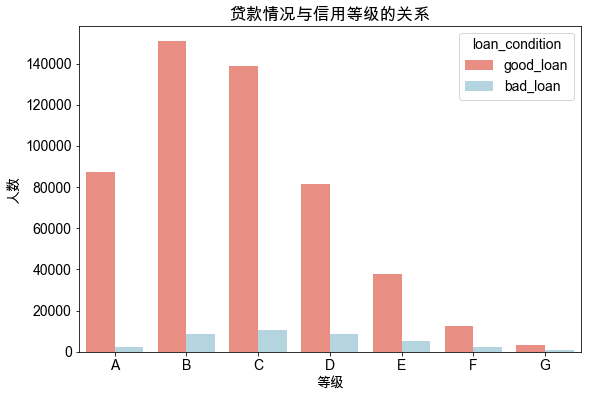

In [431]:
##贷款情况与信用等级的关系

plt.figure(figsize=(9, 6))

sns.countplot(x='grade', data=data_load_processing, hue='loan_condition', 
              palette = ['salmon', 'lightblue'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

plt.xticks(rotation = 0)
plt.xlabel('等级')
plt.ylabel('人数')
plt.title('贷款情况与信用等级的关系')

#plt.savefig('./图片/贷款情况与信用等级的关系.png')
plt.show()
plt.close()

---
+ DTI分布情况

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


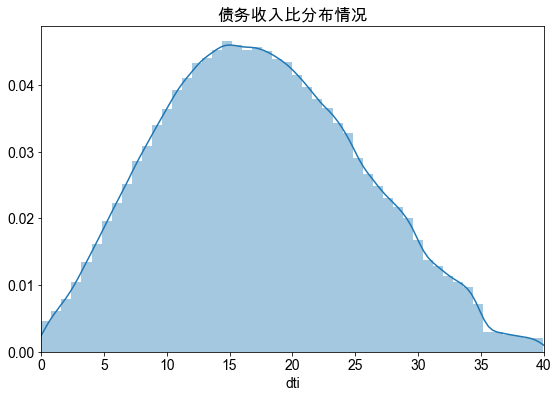

In [456]:
##DTI分布情况

plt.figure(figsize=(9, 6))

sns.distplot(data_load_processing.dti,  bins=50, kde = True)
#data_load_processing.dti.plot(kind='hist', bins=50, width = .72)
plt.xlim(left=0, right=40)

plt.title('债务收入比分布情况')

plt.savefig('./图片/债务收入比分布情况.png')
plt.show()
plt.close()

---
+ 贷款期限分布

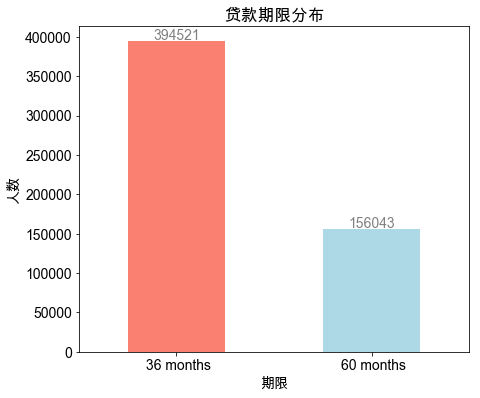

In [469]:
##贷款期限分布

plt.figure(figsize=(7, 6))

data = data_load_processing.term.value_counts()
data.plot(kind='bar', color = ['salmon', 'lightblue'])

y = list(data)
x = range(len(y))
for x,y in zip(x,y):
    plt.text(x, y+2000, str(y), ha = 'center', color = 'gray', size = 14)


plt.xticks(rotation = 0)
plt.xlabel('期限')
plt.ylabel('人数')
plt.title('贷款期限分布')

#plt.savefig('./图片/贷款期限分布.png')
plt.show()
plt.close()

----
+ 词云图

In [384]:
####词云图
data_loan_a = pd.read_csv('LoanStats3_a.csv')
data_loan_b = pd.read_csv('LoanStats3_b.csv')
data_loan_c = pd.read_csv('LoanStats3_c.csv')
data_loan_d = pd.read_csv('LoanStats3_d.csv')
data_cloud = pd.concat([data_loan_a, data_loan_b, data_loan_c, data_loan_d], ignore_index=False)  #数据框合并

In [385]:
cloud_list = ['addr_state', 'desc', 'emp_title']
str_list = ['', '', '']
for i,j in enumerate(cloud_list):  #按照index合并
    for item in data_cloud[j].dropna().values[:20000]:
        str_list[i] += str(item)+' '  #按照位置将数据放入为3个字符串

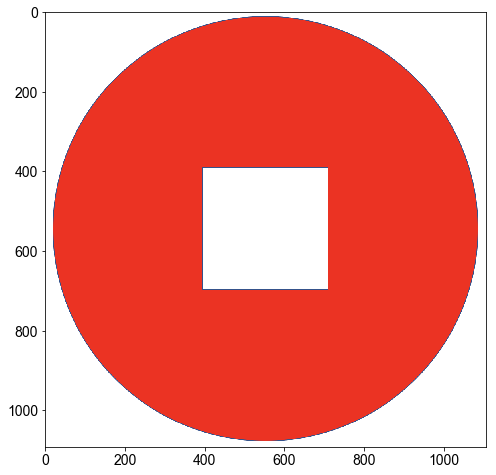

In [394]:
mask = Image.open('背景.png')
plt.imshow(mask)

In [412]:
with open('中英文停用词.txt', 'r') as f:
    stop_words = f.read()

In [416]:
stop_words = stop_words+'Borrower\n'+ 'added\n'+ 'br\n'+ 'Thank\n'+ 'you\n'+ 'will\n'+ 'be\n'+ 'this\n'+ 'my\n'+ 'to\n'
stop_words1 = re.split('\n', stop_words)

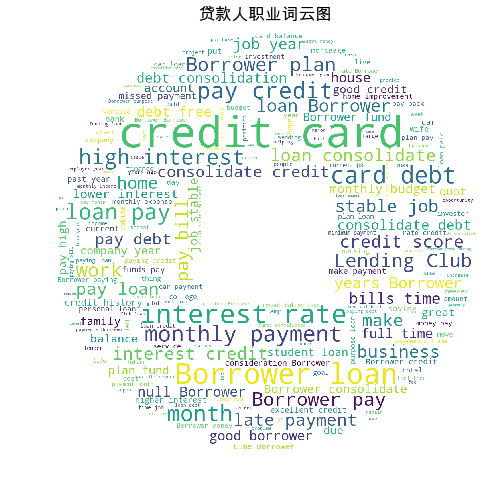

In [417]:
word_cloud = WordCloud(background_color= 'white', mask=np.array(mask), stopwords= stop_words1).generate(str_list[1])
    ###词云图 width=150, height=150, background_color= 'black', mask=np.array(mask)
plt.imshow(word_cloud)
plt.title('%s'%(title_list[k]))
plt.axis('off')
plt.savefig('./图片/%s.png'%(title_list[1]), dpi = 500, bbox_inches = 'tight')
plt.show()
plt.close()

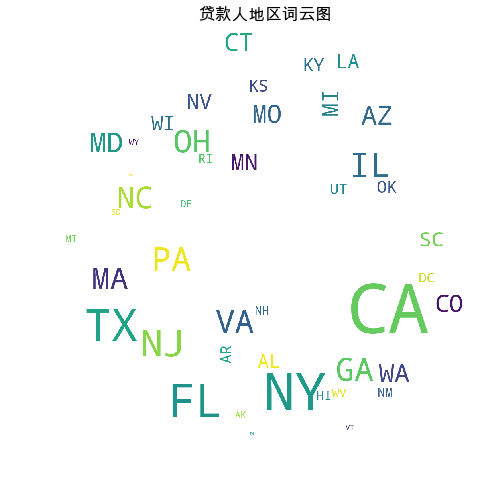

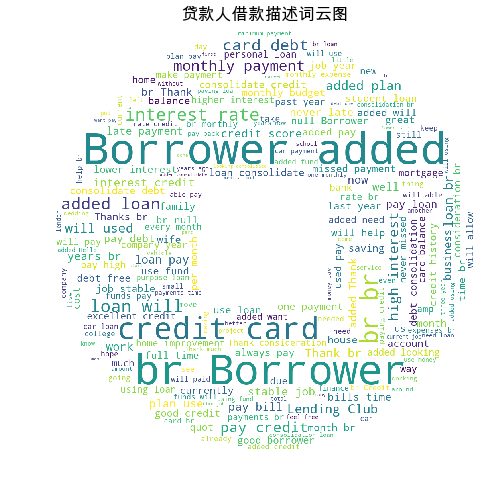

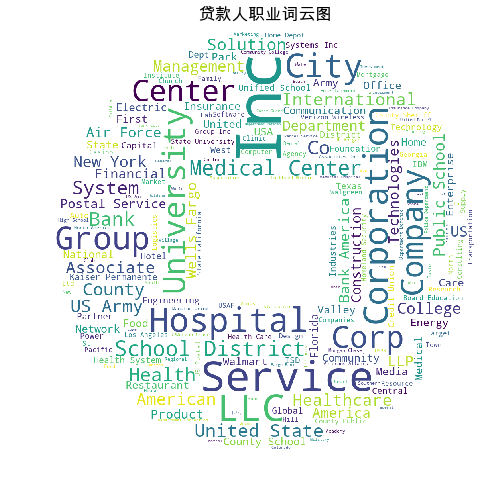

In [395]:
title_list = ['贷款人地区词云图', '贷款人借款描述词云图', '贷款人职业词云图']

for k in [0,1,2]:
    word_cloud = WordCloud(background_color= 'white', mask=np.array(mask)).generate(str_list[k])
    ###词云图 width=150, height=150, background_color= 'black', mask=np.array(mask)
    plt.imshow(word_cloud)
    plt.title('%s'%(title_list[k]))
    plt.axis('off')
    plt.savefig('./图片/%s.png'%(title_list[k]), dpi = 500, bbox_inches = 'tight')
    plt.show()
plt.close()

## <center>变量选择
+ 数据处理

In [6]:
data_model = pd.read_csv('LoanStats3_processing_2.csv')

In [8]:
data_model.iloc[:, 18:].head()

,inq_last_6mths,open_acc,pub_rec,total_acc,out_prncp,last_pymnt_amnt,revol_bal,revol_util,initial_list_status,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,policy_code,loan_condition
0,1.0,3.0,0.0,9.0,0.00,171.62,13648,83.70%,f,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0,0.0,1.0,1
1,5.0,3.0,0.0,4.0,0.00,119.66,1687,9.40%,f,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,0.0,1.0,0
2,2.0,2.0,0.0,10.0,0.00,649.91,2956,98.50%,f,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0,0.0,1.0,1
3,1.0,10.0,0.0,37.0,0.00,357.48,5598,21%,f,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0,0.0,1.0,1
4,0.0,15.0,0.0,38.0,1277.33,67.79,27783,53.90%,f,2632.060000,2632.06,1722.67,909.39,0.00,0.00,0,0.0,1.0,1


In [9]:
##处理字符型数据
str_dict = {
    'grade':{"A": 0,"B": 1,"C": 2, "D": 3, "E": 4,"F": 5,"G": 6},
    
    'emp_length':{"10+ years": 10,"9 years": 9,"8 years": 8,
                    "7 years": 7,"6 years": 6,"5 years": 5,"4 years":4,
                    "3 years": 3,"2 years": 2,"1 year": 1,"< 1 year": 0},
    
    'home_ownership':{'MORTGAGE':0, 'RENT':1, 'OWN':2, 'NONE':3, 'OTHER':4, 'ANY':5} ,#按揭，租，自有，无，其他， 任何
    
    'verification_status':{'not verified':0,  'VERIFIED - income source':1, 'VERIFIED - income':2},
    
    'pymnt_plan':{'n':0, 'y':1},
    
    'initial_list_status': {'f':0, '0': 0, 'w': 1},

    
    'purpose':{'other':0, 'small_business':1, 'home_improvement':2,
       'debt_consolidation':3, 'educational':4, 'credit_card':5, 'car':6,
       'vacation':7, 'moving':8, 'wedding':9, 'house':10, 'major_purchase':11,
       'medical':12, 'renewable_energy':13, "Paying off my son's dept...":14}  #, 'loan_condition':{'good_loan':1, 'bad_loan':0}
}

data_model_1 = data_model.replace(str_dict)
data_model_1['term'] = data_model_1['term'].str.rstrip('months').astype('float')
data_model_1 = data_model_1.replace({'term':{36: 0, 60 :1}})
data_model_1['revol_util'] = data_model_1.revol_util.str.rstrip('%').astype('float')/100

##处理变量revol_bal
revol_bal_float = []
for i in data_model_1.revol_bal:
    if '%' in str(i):
        revol_bal_float.append(float(str(i).rstrip('%'))/100)
    else:
         revol_bal_float.append(float(i))
del data_model_1['revol_bal']
data_model_1['revol_bal'] = revol_bal_float

##处理变量collection_recovery_fee
collection_recovery_fee_float = []
for i in data_model_1.collection_recovery_fee:
    if i != '11-Sep':
        collection_recovery_fee_float.append(float(i))
    else:
        collection_recovery_fee_float.append(0.0)      
data_model_1['collection_recovery_fee'] = collection_recovery_fee_float



##删除无用变量
del_name = ['sub_grade', 'issue_d', 'loan_status', 'policy_code', 'addr_state']
for name in del_name:
    del data_model_1[name]


In [ ]:
##工作机构处理
#工作机构分类，依据A政府机构类，B银行类，F医院类，E学校类，C自职业类，D公司和其它类，G退休类分类．
#如果数据中的emp_title与某个上述A-G有交集，则将它划为该类，用字母字符表示； 缺省值为’H'。
# #查看Object类型数据的缺失情况
data_model_1.select_dtypes(include=['O']).describe()\
.T.assign(missing = data_model_1.apply(lambda x : (1 - x.count() /len(x)))).sort_values(by = 'missing',ascending = False)

In [28]:
# ###处理工作类型：A：0，政府机构，B:1，银行，C:2，自由职业， D:3退休， E:4，学校，F：5，医院， G：6，公司或其他类
A = ['board', 'general', 'american', 'u.s.', 'army', 'force', 'us', 'states', 'corp', 'navy', 'united', 'department'] #政府机构
B = ['bank', 'morgan']  #银行
C = ['self']   #自职业
D = ['retired', 'retire'] #退休
E = ['college', 'school', 'university', 'teacher']  #学校类
F = ['hospital', 'clinic', 'health', 'heathcare']  #医院类
G = ['other']  #公司或其他类

list_letter = [0, 1, 2, 3, 4, 5]
ls = [A,B,C,D,E,F]


for i in data_model_1.emp_title.index:
    emp_list = []
    for j in range(len(ls)):
        emp_list.append(set(str(data_model_1.emp_title[i]).lower().split())  & set(ls[j]))
    if emp_list.count(set()) != 6:
        sr_emp = pd.Series(emp_list)
        idx = sr_emp[sr_emp!=set()].index
        data_model_1.emp_title[i] = list_letter[idx[0]]
    else:
        data_model_1.emp_title[i] = 6
    
    if i % 50000 == 0:
        print(i)

data_model_1['emp_title'] = [int(i) for i in list(data_model_1.emp_title.values)] 

In [423]:
data_model_1.to_csv('建模32个变量.csv', encoding='utf-8', index=False)

In [25]:
data_model2 = pd.read_csv('建模32个变量.csv')
data_model2.head()

,loan_amnt,funded_amnt,funded_amnt_inv,pymnt_plan,term,int_rate,grade,emp_title,emp_length,home_ownership,...,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,collections_12_mths_ex_med,revol_bal,loan_condition
0,5000.0,5000.0,4975.0,0,0,0.1065,1,6,10,1,...,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,0,13648.0,1
1,2500.0,2500.0,2500.0,0,1,0.1527,2,6,0,1,...,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,0,1687.0,0
2,2400.0,2400.0,2400.0,0,0,0.1596,2,0,10,1,...,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,0,2956.0,1
3,10000.0,10000.0,10000.0,0,0,0.1349,2,0,10,1,...,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,0,5598.0,1
4,3000.0,3000.0,3000.0,0,1,0.1269,1,4,1,1,...,2632.060000,2632.06,1722.67,909.39,0.00,0.00,0.00,0,27783.0,1


---
### <center>变量筛选
#####  去变量强相关性
+ logistic回归对变量的相关性较敏感

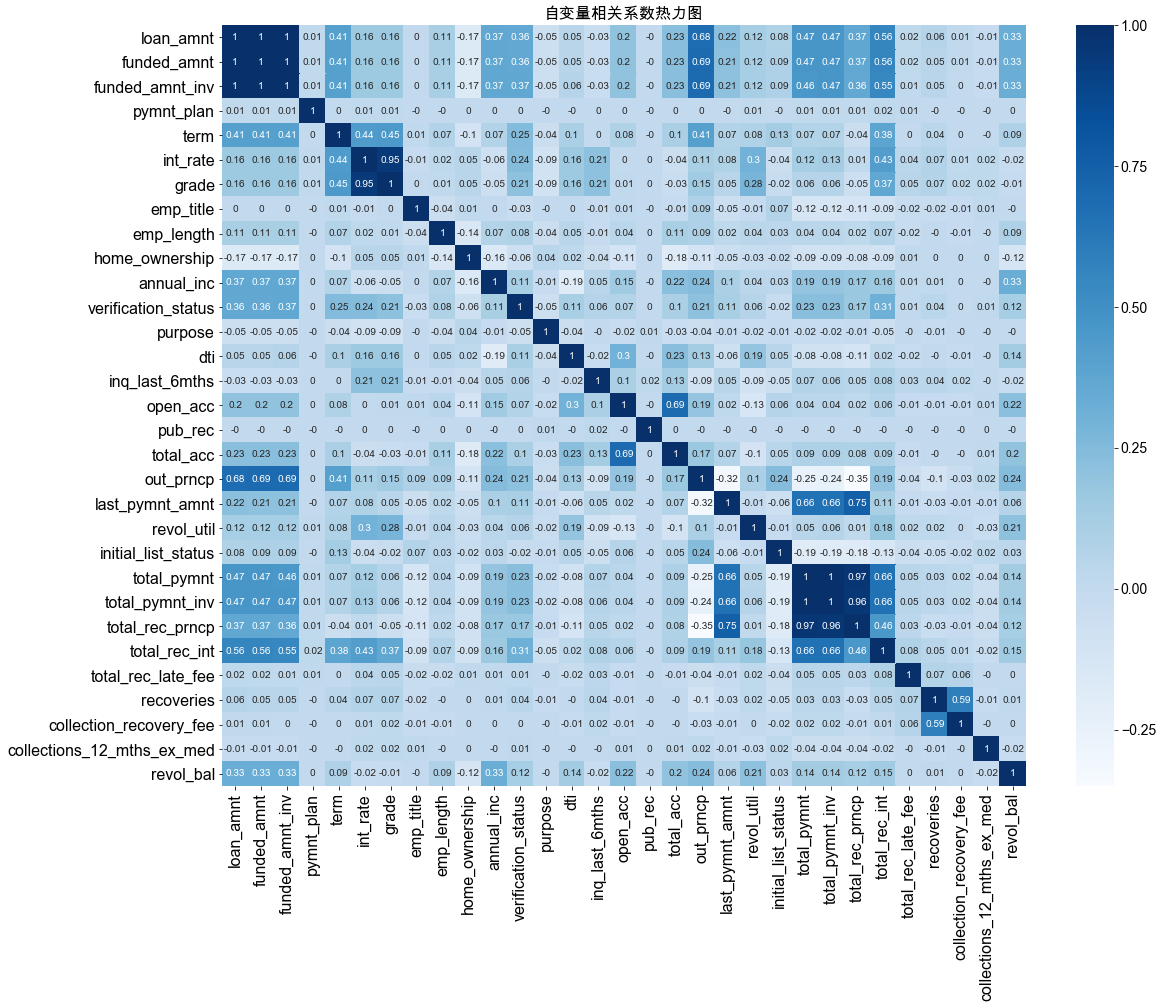

In [28]:
feature_col_names = list(data_model2.columns)
feature_col_names.remove('loan_condition')

# ###画自变量的热力图
plt.figure(figsize=(18,14))

sns.heatmap(data_model2[feature_col_names].corr().round(2), cmap='Blues', annot=True, annot_kws={'size' :10})  #保留两位有效数字，设定颜色为blues，显示数字
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.title('自变量相关系数热力图', size = 16)
#plt.savefig('./图片/自变量相关系数热力图.png', dpi = 500, bbox_inches = 'tight')

plt.show()
plt.close()

+ 相关系数热力图显示:
        loan_amnt、funded_amnt、funded_amnt_inv、out_prncp；
    
        int_rate、grade；total_acc、open_acc; 
    
        last_pymnt_amnt, total_pymnt, total_pymnt_inv, total_rec_prncp, total_rec_int;
        
        recoveries, collection_recovery_fee
    
        间的相关系数大于0.6，将其删除。
  ----
    
    
+ 计算vif值, 删除vif>10的变量。

In [42]:
###检查共线性
vif_list_name = feature_col_names

vif_list = []
for i in range(len(vif_list_name)):
    vif_list.append([vif_list_name[i],  vif(data_model2[vif_list_name].values, i)])
    
vif_df = pd.DataFrame(vif_list, columns=['features', 'vif'])
vif_df.sort_values(by = 'vif', ascending = False).style.bar()

,features,vif
22,total_pymnt,2.36459e+09
24,total_rec_prncp,1.52291e+09
25,total_rec_int,1.55532e+08
27,recoveries,2.19249e+06
1,funded_amnt,5644.57
2,funded_amnt_inv,3960.05
0,loan_amnt,1677.76
23,total_pymnt_inv,1383.4
16,pub_rec,1254.27
26,total_rec_late_fee,307.321


In [29]:
###删除变量
del_name = ['funded_amnt', 'funded_amnt_inv', 'out_prncp', 'int_rate', 'open_acc', 
           'last_pymnt_amnt', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'emp_title', 'collection_recovery_fee']   ##保留了 loan_amnt、grade、total_pymnt_inv
feature_col_names_left = [name for name in feature_col_names if name not in del_name]
print('还剩下自变量：%s个'%(len(feature_col_names_left)))

还剩下自变量：20个


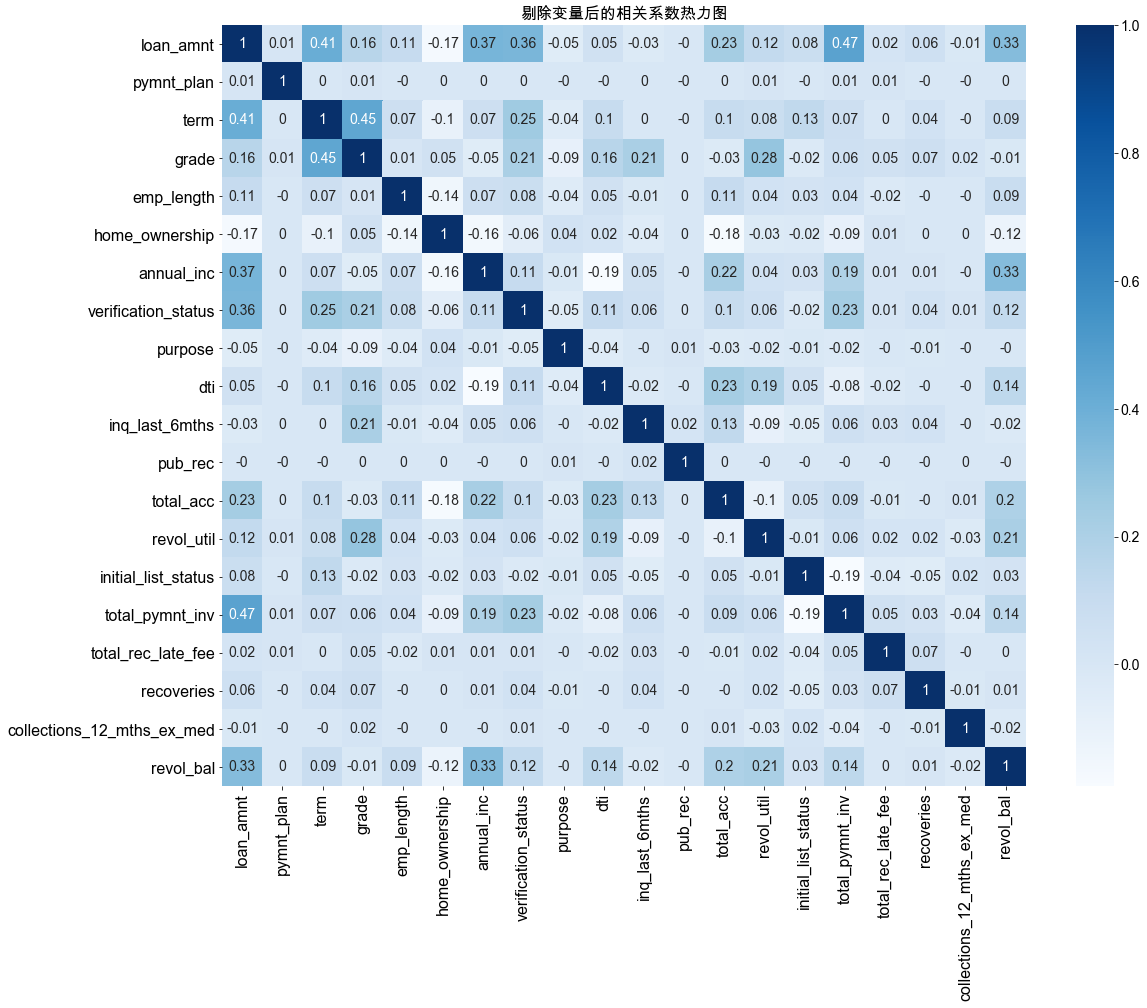

In [38]:
##还剩下20个变量

plt.figure(figsize=(18,14))

sns.heatmap(data_model2[feature_col_names_left].corr().round(2), cmap='Blues', annot=True)  #保留两位有效数字，设定颜色为blues，显示数字
plt.xticks(size = 16)
plt.yticks(size = 16)
plt.title('剔除变量后的相关系数热力图', size = 16)

#plt.savefig('./图片/剔除变量后的相关系数热力图.png')

plt.show()
plt.close()

In [39]:
###检查共线性
vif_list_name = feature_col_names_left

vif_list = []
for i in range(len(vif_list_name)):
    vif_list.append([vif_list_name[i],  vif(data_model2[vif_list_name].values, i)])
    
vif_df = pd.DataFrame(vif_list, columns=['features', 'vif'])
vif_df.sort_values(by = 'vif', ascending = False).style.bar()

,features,vif
0,loan_amnt,8.1386
13,revol_util,6.92247
9,dti,6.81253
12,total_acc,6.42661
3,grade,4.49426
8,purpose,3.65118
6,annual_inc,3.63227
4,emp_length,3.55673
7,verification_status,3.17495
15,total_pymnt_inv,2.77917


+ 剔除相关性很强的变量后，可见变量间的相关性较小
+ 20个变量的vif值都小于10.
----

##### 随机森林筛选变量
+ 接下来，通过随机森林对变量进行过滤，按照变量在随机森林模型中的重要性排序，可以剔除后面重要性很低的变量

In [30]:
###用剩下的20个变量进行筛选

feature_col_names_left.append('loan_condition') #加入因变量

data_random_forest = data_model2[feature_col_names_left]

data_1 = data_random_forest[data_random_forest['loan_condition'] == 1]
data_0=data_random_forest[data_random_forest['loan_condition'] == 0]


data_1_train, data_1_test = train_test_split(data_1, test_size=.3, random_state=10) #good
data_0_train, data_0_test = train_test_split(data_0, test_size=.3, random_state=10) #bad

train=pd.concat([data_1_train, data_0_train])
test=pd.concat([data_1_test, data_0_test])

#训练集
train_X=train.drop(['loan_condition'], axis=1)
train_y=train['loan_condition']

test_X=test.drop(['loan_condition'], axis=1)
test_y=test['loan_condition']

#resampled_X,resampled_y=SMOTE(random_state=12).fit_sample(train_X,train_y)

In [31]:
LR = LogisticRegression()
LR.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [427]:
rf = RandomForestClassifier(n_estimators=500, max_depth=7, random_state=1).fit(train_X, train_y)
importance = pd.DataFrame({'features':train_X.columns.values, 'importance':rf.feature_importances_})
importance.sort_values(by='importance',  ascending=False).style.bar()  #按照重要度降序排序

,features,importance
17,recoveries,0.810572
16,total_rec_late_fee,0.0814525
10,inq_last_6mths,0.0273731
3,grade,0.0262924
14,initial_list_status,0.012821
15,total_pymnt_inv,0.0126949
7,verification_status,0.00460206
6,annual_inc,0.0043329
0,loan_amnt,0.00316789
8,purpose,0.00293127


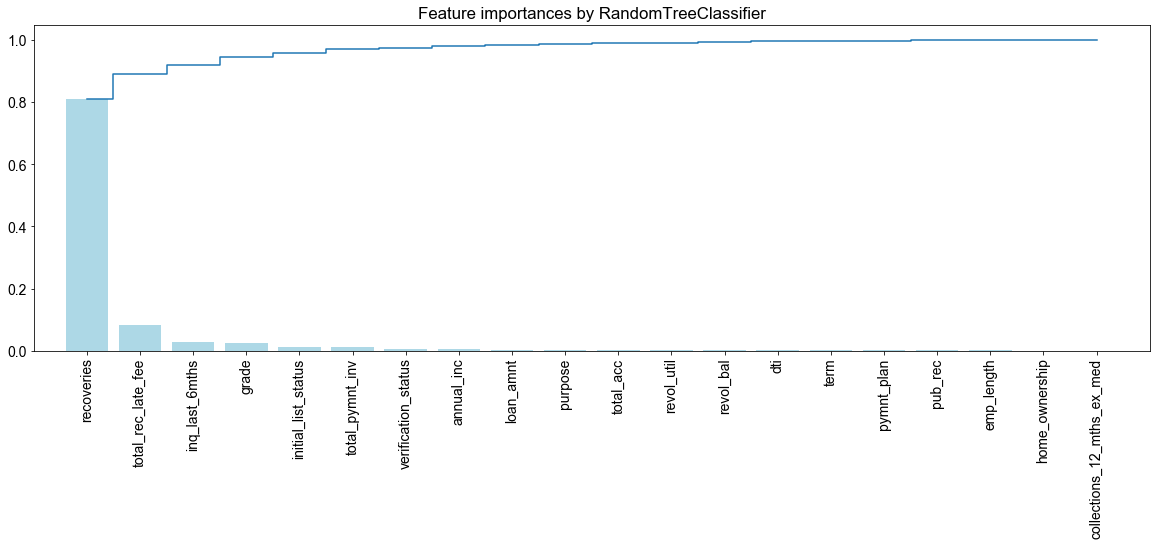

In [428]:
importance_df = importance.sort_values(by = 'importance', ascending=False)
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(importance_df)), importance_df['importance'], color='lightblue',  align="center")
plt.step(range(len(importance_df)), np.cumsum(importance_df['importance']), where='mid', label='Cumulative')
plt.xticks(range(len(importance_df)), importance_df['features'], rotation='vertical',fontsize=14)
plt.xlim([-1, len(importance_df)])

plt.savefig('./图片/重要度图.png', dpi = 500, bbox_inches = 'tight')

plt.show()


+  由于房屋拥有权对贷款有显而易见的影响，因此，该步骤删除变量pub_rec，collections_12_mths_ex_med

In [44]:
del_name = ['pub_rec', 'collections_12_mths_ex_med']
feature_col_names_left = [name for name in feature_col_names_left if name not in del_name]
len(feature_col_names_left)  #包含因变量

18

In [61]:
##vif检验一下：

vif_list_name = feature_col_names_left

vif_list = []
for i in range(len(vif_list_name)):
    vif_list.append([vif_list_name[i],  vif(data_model2[vif_list_name].values, i)])
    
vif_df = pd.DataFrame(vif_list, columns=['features', 'vif'])
vif_df.sort_values(by = 'vif', ascending = False).style.bar()

,features,vif
0,loan_amnt,8.13831
12,revol_util,6.91816
9,dti,6.81234
11,total_acc,6.42347
3,grade,4.48797
8,purpose,3.65076
6,annual_inc,3.63185
4,emp_length,3.55657
7,verification_status,3.17377
14,total_pymnt_inv,2.77643


In [148]:
data_rfc = data_model2[feature_col_names_left]
data_rfc['target'] = data_model2['loan_condition']

In [66]:
data_1 = data_rfc[data_rfc['target'] == 1]
data_0 = data_rfc[data_rfc['target'] == 0]

data_1_train, data_1_test = train_test_split(data_1, test_size=.3, random_state=10) #good
data_0_train, data_0_test = train_test_split(data_0, test_size=.3, random_state=10) #bad

train=pd.concat([data_1_train, data_0_train])
test=pd.concat([data_1_test, data_0_test])

#训练集
train_X=train.drop(['target'], axis=1)
train_y=train['target']

test_X=test.drop(['target'], axis=1)
test_y=test['target']

#resampled_X,resampled_y=SMOTE(random_state=12).fit_sample(train_X,train_y)

rf = RandomForestClassifier(n_estimators=500, max_depth=7, random_state=1).fit(train_X, train_y)
importance2 = pd.DataFrame({'features':train_X.columns.values, 'importance':rf.feature_importances_})
importance2.sort_values(by='importance',  ascending=False).style.bar()  #按照重要度降序排序

,features,importance
16,recoveries,0.827065
15,total_rec_late_fee,0.0727551
10,inq_last_6mths,0.0256629
3,grade,0.0251474
14,total_pymnt_inv,0.011878
13,initial_list_status,0.0118264
7,verification_status,0.00470932
6,annual_inc,0.0038335
0,loan_amnt,0.00315572
8,purpose,0.00239078


+ 至此，变量通过了vif和重要度检验
----

In [69]:
data_model3 = data_model2[feature_col_names_left]
data_model3['target'] = data_model2['loan_condition']


In [72]:
data_model3.loc[data_model3['target']==1, 'target'] = 2
data_model3.loc[data_model3['target']==0, 'target'] = 1
data_model3.loc[data_model3['target']==2, 'target'] = 0

In [75]:
data_model3.to_csv('18个特征.csv', encoding='utf-8', index=False)

In [76]:
df_iv = pd.read_csv('18个特征.csv')
df_iv.head()

,loan_amnt,pymnt_plan,term,grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,inq_last_6mths,total_acc,revol_util,initial_list_status,total_pymnt_inv,total_rec_late_fee,recoveries,revol_bal,target
0,5000.0,0,0,1,10,1,24000.0,2,5,27.65,1,9.0,0.837,0,5831.78,0.00,0.00,13648.0,0
1,2500.0,0,1,2,0,1,30000.0,1,6,1.00,5,4.0,0.094,0,1008.71,0.00,117.08,1687.0,1
2,2400.0,0,0,2,10,1,12252.0,0,1,8.72,2,10.0,0.985,0,3003.65,0.00,0.00,2956.0,0
3,10000.0,0,0,2,10,1,49200.0,1,0,20.00,1,37.0,0.210,0,12226.30,16.97,0.00,5598.0,0
4,3000.0,0,1,1,1,1,80000.0,1,0,17.94,0,38.0,0.539,0,2632.06,0.00,0.00,27783.0,0


----
+ 最后，再基于IV值筛选变量
<center>用IV解释预测力</center>

|IV值|预测力|
|---|---|
|<0.02|无预测力|
|0.02~0.10|弱|
|0.10~0.30|中等|
|>0.30|强|

##### 卡方分箱
+ 在逻辑回归建立评分卡的过程中，变量的分箱是很重要的一步。下面将对剩下的连续性变量进行卡方分箱，并计算所有变量的WOE和IV值，并根据IV值进行最后的筛选。

+ 特征分箱有如下好处：

       特征分箱后，特征被简化，也简化了模型，比如在逻辑回归评分卡模型中，评分卡被简化，
       基于决策树的模型中，决策树枝杈减少，降低了过拟合的风险，有效增加了模型的稳定性。

        特征分箱可以将缺失值划为一类，比如此样本中无法被编码的公共记录缺失类。

        特征离散化后对异常数据也有更强的容错性。
        比如假设年龄数据中出现1000岁，模型可以自动将其划分为>80岁一类，否则它会对对异常值敏感的模型如（逻辑回归）造成很大影响。

        特征离散化之后，方便进一步进行非线性的特征衍生。
        
+ 分箱的方法：

        常用的分箱方法包括卡方分箱、等频或等距分箱、聚类、依据经验分箱等。

        对连续型数值变量，在此采用有监督的最优分箱法——卡方分箱。

In [2]:
#计算WOE和IV值
def CalcWOE(df,col, target):
    '''
    : df dataframe
    : col 注意这列已经分过箱了，现在计算每箱的WOE和总的IV
    ：target 目标列 0-1值
    ：return 返回每箱的WOE和总的IV
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total':total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad':bad})
    regroup = total.merge(bad, left_index = True, right_index = True, how = 'left')
    regroup.reset_index(level = 0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x*1.0/G)
    
    ###WOE表示对不同特征对好样本的预测能力，这符合评分卡标准，分数越高，越可信
    regroup['WOE'] = np.log(regroup.good_pcnt * 1.0/regroup.bad_pcnt)
    WOE_dict = regroup[[col, 'WOE']].set_index(col).to_dict()
    IV = (regroup.good_pcnt - regroup.bad_pcnt) * np.log(regroup.good_pcnt * 1.0 / regroup.bad_pcnt)
    IV_SUM = sum(IV)
    return IV_SUM
    #return {'WOE':WOE_dict, 'IV_sum': IV_SUM, 'IV':IV}


In [80]:
continuous_name = ['loan_amnt', 'annual_inc', 'dti', 'inq_last_6mths',
             'total_acc', 'revol_util', 'total_pymnt_inv', 'total_rec_late_fee', 
             'recoveries', 'revol_bal']  #连续型变量

data_woe = df_iv #用于存储所有数据的woe值
data = df_iv.copy()
civ_list = []

bad_total = sum(data['target'])  #bad为1
good_total = len(data) - bad_total

for column in list(data.columns[:-1]):
    if column in continuous_name:  #连续变量
        civ = fp.proc_woe_continuous(data, column, bad_total, good_total, 0.05*len(data), alpha=0.01)
    else:             #离散型变量
        civ = fp.proc_woe_discrete(data, column, bad_total, good_total, 0.05*len(data), alpha=0.01)
    civ_list.append(civ)
    
    data_woe[column] = fp.woe_trans(data[column], civ)

-----------process continuous variable:loan_amnt------------
------------process discrete variable:pymnt_plan------------
---------------process discrete variable:term---------------
--------------process discrete variable:grade---------------
------------process discrete variable:emp_length------------
----------process discrete variable:home_ownership----------
-----------process continuous variable:annual_inc-----------
-------process discrete variable:verification_status--------
-------------process discrete variable:purpose--------------
--------------process continuous variable:dti---------------
---------process continuous variable:inq_last_6mths---------
-----------process continuous variable:total_acc------------
-----------process continuous variable:revol_util-----------
-------process discrete variable:initial_list_status--------
--------process continuous variable:total_pymnt_inv---------
-------process continuous variable:total_rec_late_fee-------
-----------process conti

In [81]:
data_woe.to_csv('woe.csv', index=False, encoding='utf-8')  #woe值

In [82]:
data_civ = eval.eval_feature_detail(Info_Value_list=civ_list,out_path=False)   #IV值

loan_amnt
pymnt_plan
term
grade
emp_length
home_ownership
annual_inc
verification_status
purpose
dti
inq_last_6mths
total_acc
revol_util
initial_list_status
total_pymnt_inv
total_rec_late_fee
recoveries
revol_bal


In [132]:
data_civ.to_csv('civ值.csv', encoding='utf-8', index=False)  #输出的iv表

In [121]:
civ22 = []
for name in data_woe.columns[:-1]:
    civ = CalcWOE(data_woe, str(name), 'target')   #该函数用于求iv值，求出来的iv值和woe包中输出的iv值相同
    civ22.append({name: civ})

#转化为dataframe
civ22_pd = pd.DataFrame(columns=['features', 'civ'])
i = 0
for name in civ22:
    civ22_pd.loc[i, 'features'] = list(name.keys())[0]
    civ22_pd.loc[i, 'civ'] = list(name.values())[0]
    i +=1

civ22_pd.sort_values(by = 'civ', ascending=False).style.bar()

,features,civ
3,grade,0.253992
15,total_rec_late_fee,0.211186
13,initial_list_status,0.135765
10,inq_last_6mths,0.125992
14,total_pymnt_inv,0.0818576
8,purpose,0.0566631
6,annual_inc,0.0526714
7,verification_status,0.0364989
12,revol_util,0.0323092
5,home_ownership,0.0231244


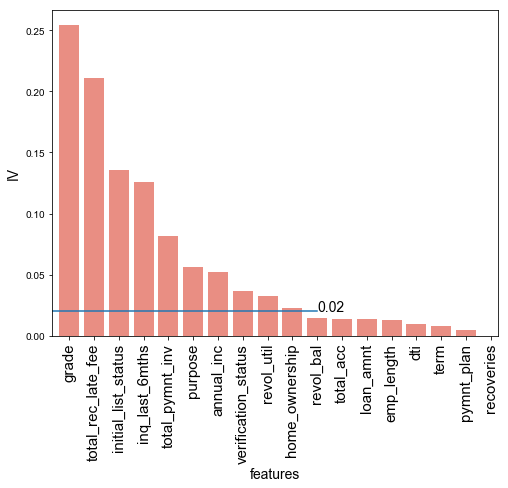

In [131]:
plt.figure(figsize=(8,6))
iv_plot = civ22_pd.sort_values(by = 'civ', ascending=False)
sns.barplot(iv_plot.features, iv_plot.civ, palette = ['salmon'])
plt.plot([-0.7,10], [0.02, 0.02])
plt.text(10, 0.0202, '0.02', size= 14)

#plt.title('缺失比例图', size = 14)
plt.xticks(rotation = 90, size = 14)
plt.xlabel('features', size = 14)
plt.ylabel('IV', size = 14)
plt.xticks(size = 15)
plt.xlim(-0.7,17.3)

plt.savefig('./图片/IV.png')
plt.show()
plt.close()

In [114]:
##选择iv值大于0.02的选项
last_feature_name = list(civ22_pd.loc[civ22_pd['civ'] >0.02, 'features'])
last_feature_name

['grade',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'inq_last_6mths',
 'revol_util',
 'initial_list_status',
 'total_pymnt_inv',
 'total_rec_late_fee']

In [115]:
###
#分箱后数据
last_feature_name.append('target')
df_bins = data_woe[last_feature_name]  #用于建模

In [133]:
df_bins.to_csv('分箱后的数据.csv', index=False, encoding='utf-8')

----
##  <center>构建评分卡

In [71]:
##用十个变量重新分箱
df_bins = pd.read_csv('分箱后的10个变量.csv')
df_bins.head()

,grade,home_ownership,annual_inc,verification_status,purpose,inq_last_6mths,revol_util,initial_list_status,total_pymnt_inv,total_rec_late_fee,target
0,-0.302222,0.158591,0.429867,0.212031,-0.337020,0.017816,0.212631,0.238858,0.175153,-0.084884,0
1,0.003022,0.158591,0.272923,-0.251077,0.471191,0.846641,-0.032384,0.238858,-0.103899,-0.084884,1
2,0.003022,0.158591,0.429867,-0.013387,0.471191,0.300712,0.329812,0.238858,0.227130,-0.084884,0
3,0.003022,0.158591,0.143467,-0.251077,0.471191,0.017816,-0.281186,0.238858,-0.196406,2.528452,0
4,-0.302222,0.158591,-0.139797,-0.251077,0.471191,-0.286060,-0.107580,0.238858,0.227130,-0.084884,0


 ---
 + logistic回归求系数

In [72]:
data_1 = df_bins[df_bins['target'] == 1]  #1是坏蛋
data_0 = df_bins[df_bins['target'] == 0]


data_1_train, data_1_test = train_test_split(data_1, test_size=.2, random_state=10) #good
data_0_train, data_0_test = train_test_split(data_0, test_size=.2, random_state=10) #bad

train=pd.concat([data_1_train, data_0_train])
test=pd.concat([data_1_test, data_0_test])

#训练集,
train_X=train.drop(['target'], axis=1)
train_y=train['target']

test_X=test.drop(['target'], axis=1)
test_y=test['target']

train_X=sm.add_constant(train_X)
logit3=sm.Logit(train_y,train_X).fit()
logit3.summary()

Optimization terminated successfully.
         Current function value: 0.226968
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:               440462
Model:                          Logit   Df Residuals:                   440451
Method:                           MLE   Df Model:                           10
Date:                Wed, 19 Jun 2019   Pseudo R-squ.:                  0.1086
Time:                        17:39:28   Log-Likelihood:                -99971.
converged:                       True   LL-Null:                   -1.1215e+05
                                        LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.5802      0.006   -398.222      0.000      -2.593      -2.568
grade                   0.7947      0.014     58.248      0.000       0.768       0.821
home_ownership          0.5232      0.042     12.580      0.000       0.442       0.605
annual_inc              0.6033      0.028     21.495      0.000       0.548       0.658
verification_status     0.8980      0.033     27.548      0.000       0.834       0.962
purpose                 0.4807      0.026     18.692      0.000       0.430       0.531
inq_last_6mths          0.7960      0.017     47.209      0.000       0.763       0.829
revol_util              0.7305      0.035     20.612      0.000       0.661       0.800
initial_list_status     0.9197      0.018     50.810      0.000       0.884       0.955
total_pymnt_inv         1.2356      0.025     50.400      0.000       1.188       1.284
total_rec_late_fee      0.9187      0.011     81.720      0.000       0.897       0.941
=======================================================================================
"""

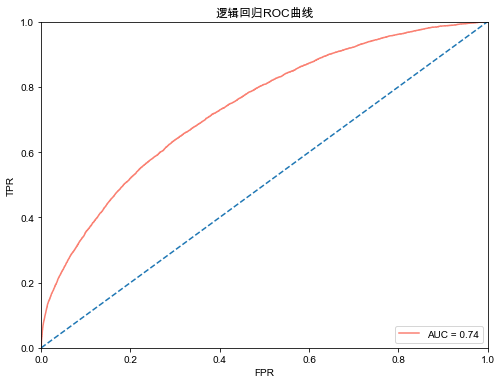

In [73]:
test_X = sm.add_constant(test_X)
y_pre_bin = logit3.predict(test_X)
fpr2, tpr2, th2 = roc_curve(test_y, y_pre_bin)
rocauc = auc(fpr2, tpr2)

plt.figure(figsize=(8,6))
plt.plot(fpr2, tpr2, 'salmon', label='AUC = %.2f' %rocauc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('逻辑回归ROC曲线')
plt.savefig('./图片/逻辑回归ROC曲线.png')
plt.show()
plt.close()

In [74]:
ks = max(tpr2 - fpr2)
print('ks=', ks)

ks= 0.33823019201582694


-----
## 评分卡

In [75]:
logit3.params

const                 -2.580238
grade                  0.794711
home_ownership         0.523153
annual_inc             0.603299
verification_status    0.898022
purpose                0.480737
inq_last_6mths         0.795970
revol_util             0.730461
initial_list_status    0.919675
total_pymnt_inv        1.235568
total_rec_late_fee     0.918725
dtype: float64

In [76]:
##计算A、B和初始得分
##具体评分表见附件
B=20/np.log(2)
A=600+20*np.log(1/60)/np.log(2)

basescore=round(A-B*logit3.params[0], 0)
print(A)
print(B)
print(basescore)

481.8621880878296
28.85390081777927
556.0


+ 详细数据见评分卡

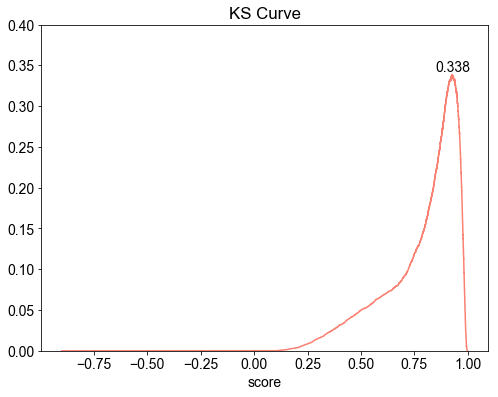

In [97]:
###平方卡评价  ---KS曲线
plt.rc('font', size = 14)
plt.figure(figsize=(8,6))

#plt.plot(1 - th2, tpr2, label='tpr') # ks曲线要按照预测概率降序排列，所以需要1-threshold镜像
#plt.plot(1 - th2, fpr2, label='fpr')
plt.plot(1 - th2, tpr2-fpr2, color = 'salmon')  #KS曲线
plt.xlabel('score')
plt.title('KS Curve')
plt.ylim([0.0, 0.4])

ks =  round(max(tpr2 - fpr2), 3)
plt.text(0.85, ks+0.005 , str(ks))

#plt.legend(loc='upper left')
plt.savefig('./图片/KS曲线.png')

plt.show()
plt.close()

---
### <center>预测模型
+ logistic模型
+ SVM模型
+ 决策树模型



+ 原数据
+ 上采样数据
+ 下采样数据

+ 处理样本不均衡
        目标变量“loan_condition”正常和违约两种类别的数量差别较大，会对模型学习造成困扰。我们采用过采样的方法来处理样本不均衡问题，具体操作使用的是SMOTE（Synthetic Minority Oversampling Technique），SMOET的基本原理是：采样最邻近算法，计算出每个少数类样本的K个近邻，从K个近邻中随机挑选N个样本进行随机线性插值，构造新的少数样本，同时将新样本与原数据合成，产生新的训练集。


In [2]:
data_18 = pd.read_csv('18个特征.csv')
features_10 = ['grade', 'home_ownership', 'annual_inc', 'verification_status', 
               'purpose', 'inq_last_6mths', 'revol_util', 'initial_list_status', 
               'total_pymnt_inv', 'total_rec_late_fee', 'target']
data_prediction_10 = data_18[features_10]  #10个特征
data_prediction_10.head()

,grade,home_ownership,annual_inc,verification_status,purpose,inq_last_6mths,revol_util,initial_list_status,total_pymnt_inv,total_rec_late_fee,target
0,1,1,24000.0,2,5,1,0.837,0,5831.78,0.00,0
1,2,1,30000.0,1,6,5,0.094,0,1008.71,0.00,1
2,2,1,12252.0,0,1,2,0.985,0,3003.65,0.00,0
3,2,1,49200.0,1,0,1,0.210,0,12226.30,16.97,0
4,1,1,80000.0,1,0,0,0.539,0,2632.06,0.00,0


In [3]:
##正负样本数据量不对称
X = data_prediction_10.iloc[:,:-1]
y = data_prediction_10["target"]
 
n_sample = y.shape[0]

n_bad = y[y == 1].shape[0]  #1为bad
n_good = y[y == 0].shape[0]

print('样本个数：{}; bad样本占{:.2%}; good样本占{:.2%}'.format(n_sample,
                                                   n_bad / n_sample,
                                                   n_good / n_sample))
print('特征维数：', X.shape[1])

样本个数：550579; bad样本占7.04%; good样本占92.96%
特征维数： 10


In [12]:
#混淆矩阵
def plot_confusion_matrix(y_test, y_pre, figsize = (8, 6), title= 'Confusion matrix', save_name = '混淆矩阵', cmap=plt.cm.Pastel1):
    """
    This function prints and plots the confusion matrix.
    """
    classes = [0, 1]
    cm =  confusion_matrix(y_test, y_pre)
    print('召回率：%s'%(cm[1,1]/(cm[1,1] + cm[1,0])))
    
    plt.figure(figsize=figsize)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()   #颜色设定
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "white")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('./图片/%s.png'%(save_name))
    plt.show()
    plt.close()

In [13]:
def plot_ROC(y_test, y_pre, figsize = (8, 6), title = 'ROC Curve', color = 'salmon', save_name = 'ROC曲线'):

    fpr2, tpr2, th2 = roc_curve(y_test, y_pre)
    rocauc = auc(fpr2, tpr2)
    
    plt.figure(figsize=figsize)
    plt.plot(fpr2, tpr2, color, label='AUC = %.2f' %rocauc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], '--')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(title)
    plt.savefig('./图片/%s.png'%(save_name))
    plt.show()
    plt.close()

-----
+ logistic
    + 原数据

In [4]:
data_1 = data_prediction_10[data_prediction_10['target'] == 1]
data_0 = data_prediction_10[data_prediction_10['target'] == 0]


data_1_train, data_1_test = train_test_split(data_1, test_size=.3, random_state=10) #bad
data_0_train, data_0_test = train_test_split(data_0, test_size=.3, random_state=10) #bgood

train=pd.concat([data_1_train, data_0_train])

test=pd.concat([data_1_test, data_0_test])

#训练集
X_train=train.drop(['target'], axis=1)
y_train=train['target']

X_test=test.drop(['target'], axis=1)
y_test=test['target']


In [137]:
##logistic模型

lg = LogisticRegression(C=1, solver='newton-cg', multi_class='multinomial')
lg.fit(X_train, y_train)
y_pre_logit = lg.predict(X_test)

召回率：0.03896439015998624


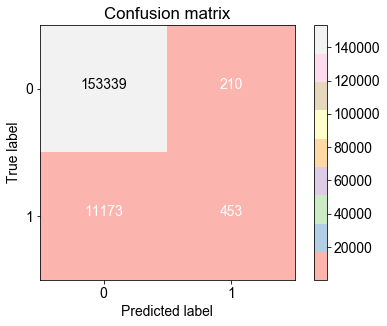

In [146]:
##混淆矩阵
plot_confusion_matrix(y_test, y_pre_logit, figsize=(6,4.5),save_name='原样本logistic预测模型混淆矩阵')

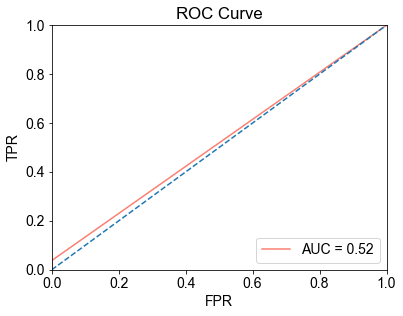

In [149]:
###ROC曲线
plot_ROC(y_test, y_pre_logit, save_name='原样本logistic预测模型ROC曲线', figsize=(6,4.5))

In [119]:
##交叉验证
scores = cross_val_score(lg, X, y, cv = 5, scoring='accuracy')

print('logistic的交叉验证结果：%s'%(scores.mean()))

logistic的交叉验证结果：0.9296177297156409


---
+ 下采样

In [5]:
from random import  sample

In [6]:
data_low_1 = data_prediction_10[data_prediction_10['target'] == 1]
data_low_00 = data_prediction_10[data_prediction_10['target'] == 0].reset_index()
del data_low_00['index']

ind = sample(range(data_low_00.shape[0]), data_low_1.shape[0])
data_low_0 = data_low_00.iloc[ind, :]

data_low_1_train, data_low_1_test = train_test_split(data_low_1, test_size=.3, random_state=10) #bad
data_low_0_train, data_low_0_test = train_test_split(data_low_0, test_size=.3, random_state=10) #bgood

train_low=pd.concat([data_low_1_train, data_low_0_train], ignore_index=True)  #重新编index

test_low=pd.concat([data_low_1_test, data_low_0_test], ignore_index=True)

#训练集
X_train_low=train_low.drop(['target'], axis=1)
y_train_low=train_low['target']

X_test_low=test_low.drop(['target'], axis=1)
y_test_low=test_low['target']


In [176]:
##logitstic模型
lg_low = LogisticRegression(C=1, solver='newton-cg', multi_class='multinomial')
lg_low.fit(X_train_low, y_train_low)
y_pre_logit_low = lg_low.predict(X_test_low)

召回率：0.6369344572509892


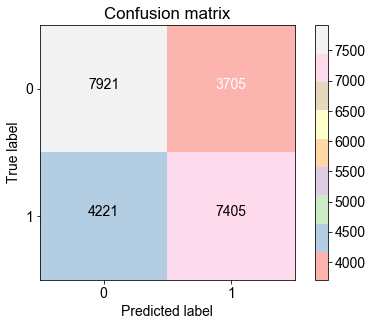

In [184]:
##混淆矩阵
plot_confusion_matrix(y_test_low, y_pre_logit_low, figsize=(6,4.5),save_name='下采样logistic预测模型混淆矩阵')

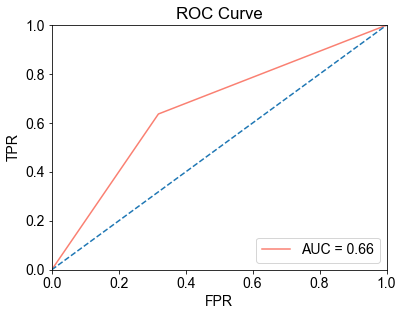

In [185]:
###ROC曲线
plot_ROC(y_test_low, y_pre_logit_low, save_name='下采样logistic预测模型ROC曲线', figsize=(6,4.5))

In [186]:
##交叉验证
data_low = pd.concat([data_low_1, data_low_0], ignore_index=True)

X_low = data_low.drop(['target'], axis = 1)
y_low = data_low['target']

scores = cross_val_score(lg_low, X_low, y_low, cv = 5, scoring='accuracy')
print('下采样logistic的交叉验证结果：%s'%(scores.mean()))

下采样logistic的交叉验证结果：0.6454142907678926


---
+ SMOTE上采样

In [7]:
# 处理不平衡数据
smt = SMOTE(random_state=42)    # 处理过采样的方法
X_up, y_up = smt.fit_sample(X, y)

print('通过SMOTE方法平衡正负样本后')
n_sample = y_up.shape[0]
n_pos_sample = y_up[y_up== 0].shape[0]
n_neg_sample = y_up[y_up == 1].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))


通过SMOTE方法平衡正负样本后
样本个数：1023656; 正样本占50.00%; 负样本占50.00%


In [8]:
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up, test_size = 0.3, random_state = 0) 

In [206]:
lg_up = LogisticRegression(C=1e5, solver='newton-cg', multi_class='multinomial')
lg_up.fit(X_train_up, y_train_up)
y_pre_logit_up = lg_up.predict(X_test_up)

召回率：0.6694874432047493


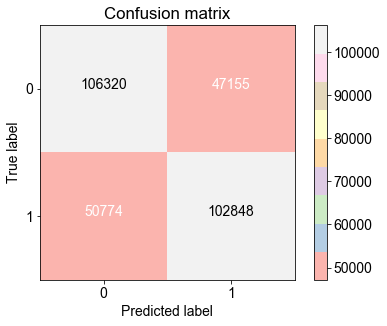

In [207]:
##混淆矩阵
plot_confusion_matrix(y_test_up, y_pre_logit_up, figsize=(6,4.5),save_name='上采样logistic预测模型混淆矩阵')

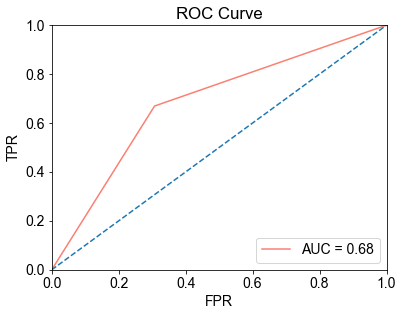

In [208]:
###ROC曲线
plot_ROC(y_test_up, y_pre_logit_up, save_name='上采样logistic预测模型ROC曲线', figsize=(6,4.5))

In [209]:
##交叉验证
scores = cross_val_score(lg_up, X_up, y_up, cv = 5, scoring='accuracy')
print('下采样logistic的交叉验证结果：%s'%(scores.mean()))

下采样logistic的交叉验证结果：0.6563640158383492


+ 使用上采样数据构建预测模型
---


---
### 决策树

In [15]:
from sklearn.tree import DecisionTreeClassifier
plt.rc('font', size = 14)

In [10]:
decision_tree = DecisionTreeClassifier(min_samples_split=50, random_state=0)
decision_tree.fit(X_train_up, y_train_up)
decision_tree_pre = decision_tree.predict(X_test_up)

召回率：0.9255705563005299


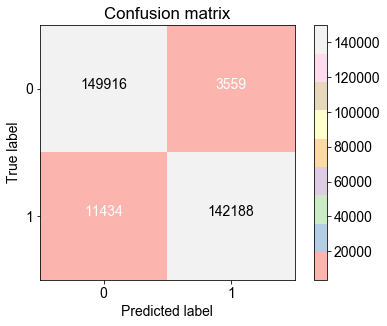

In [16]:
##混淆矩阵
plot_confusion_matrix(y_test_up, decision_tree_pre, figsize=(6,4.5),save_name='上采样决策树预测模型混淆矩阵')

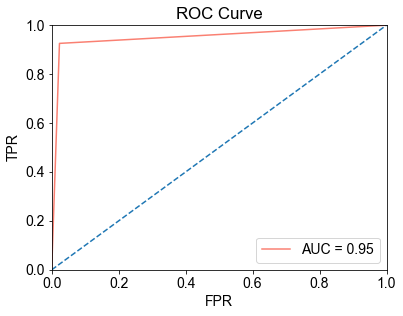

In [17]:
###ROC曲线
plot_ROC(y_test_up, decision_tree_pre, save_name='上采样决策树预测模型ROC曲线', figsize=(6,4.5))

In [18]:
##交叉验证
scores = cross_val_score(decision_tree, X_up, y_up, cv = 5, scoring='accuracy')
print('上采样决策树的交叉验证结果：%s'%(scores.mean()))

上采样决策树的交叉验证结果：0.9291598422032221


In [19]:
name = list(data_prediction_10.columns)
name.remove('target')
name

['grade',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'purpose',
 'inq_last_6mths',
 'revol_util',
 'initial_list_status',
 'total_pymnt_inv',
 'total_rec_late_fee']

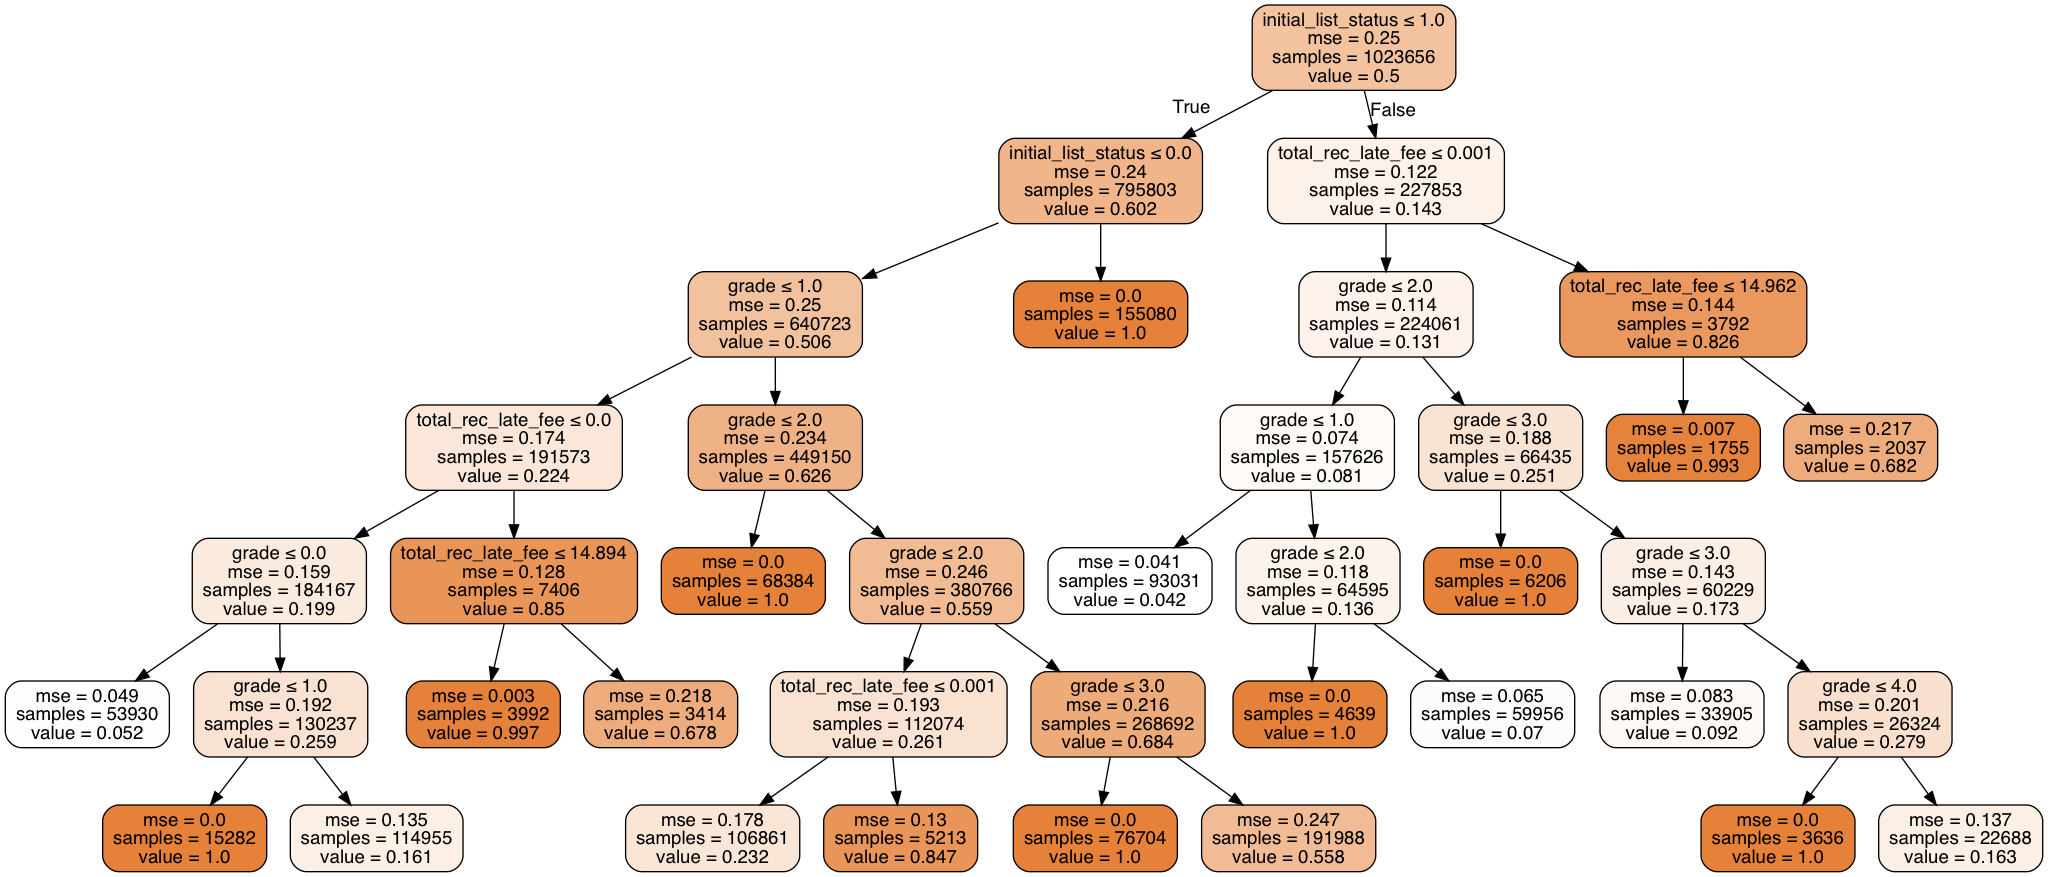

In [28]:
###可视化

from IPython.display import Image 
from sklearn import tree
import pydotplus 

tree2 = tree.DecisionTreeRegressor(max_depth=5, max_features=10, max_leaf_nodes=20)
tree2.fit(X_up, y_up)
dot_data = tree.export_graphviz(tree2, out_file=None,  #tree2是对应分类器
                         feature_names=name,   #对应特征的名字
                         class_names=['target'],    #对应类别的名字
                         filled=True, rounded=True,  
                         special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data) ##可视化工具 
graph.write_pdf('./图片/决策树可视化.pdf')    #保存图像
Image(graph.create_png())

---
+ 随机森林

In [32]:
# 随机森林
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_up, y_up)
y_pre_rfc = rfc.predict(X_test_up)

In [30]:
scores = cross_val_score(rfc, X_up, y_up)
print('随机森林准确率：',scores.mean())

随机森林准确率： 0.9425091142689453


召回率：0.9868117847704105


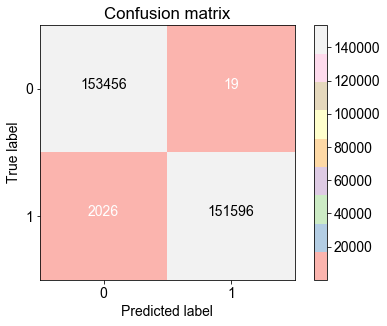

In [33]:
##混淆矩阵
plot_confusion_matrix(y_test_up, y_pre_rfc, figsize=(6,4.5),save_name='上采样随机森林预测模型混淆矩阵')

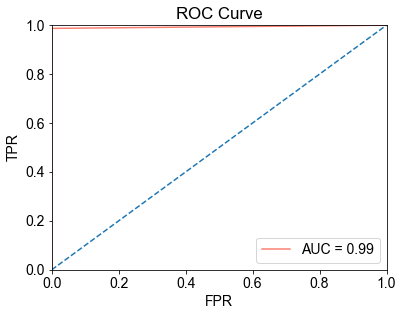

In [38]:
###ROC曲线
plot_ROC(y_test_up, y_pre_rfc, save_name='上采样随机森林预测模型ROC曲线', figsize=(6,4.5))

---

+ AdaBoost

In [35]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier(n_estimators=100)
abc.fit(X_up, y_up)
y_pre_abc = abc.predict(X_test_up)

In [40]:
scores = cross_val_score(abc, X_up, y_up)
print('AdaBoost准确率：',scores.mean())

AdaBoost准确率： 0.9372397707418707


召回率：0.9173946439963027


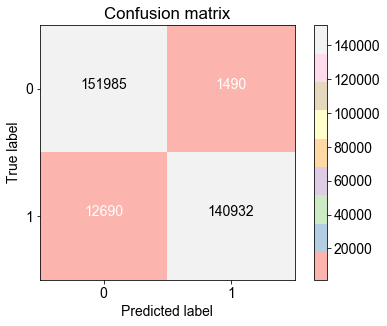

In [36]:
##混淆矩阵
plot_confusion_matrix(y_test_up, y_pre_abc, figsize=(6,4.5),save_name='上采样AdaBoost预测模型混淆矩阵')

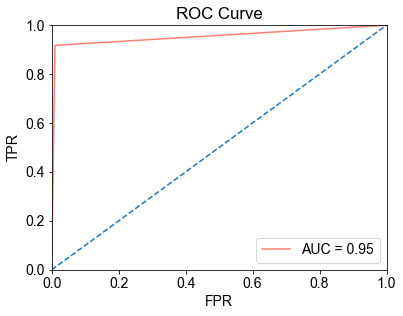

In [39]:
###ROC曲线
plot_ROC(y_test_up, y_pre_abc, save_name='上采样AdaBoost预测模型ROC曲线', figsize=(6,4.5))

---
+ Gradient Tree Boosting（梯度树提升）

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(learning_rate=1.0, max_depth=2, random_state=0)
gbc.fit(X_train_up, y_train_up)
y_pre_gbc = gbc.predict(X_test_up)

In [44]:
scores = cross_val_score(gbc, X_up, y_up)
print('GDBT准确率：',scores.mean())

GDBT准确率： 0.947478570971966


召回率：0.9267943393524365


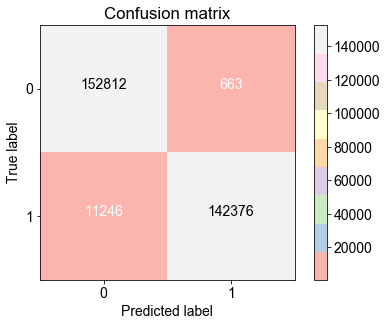

In [42]:
##混淆矩阵
plot_confusion_matrix(y_test_up, y_pre_gbc, figsize=(6,4.5),save_name='上采样Gradient Tree Boosting预测模型混淆矩阵')

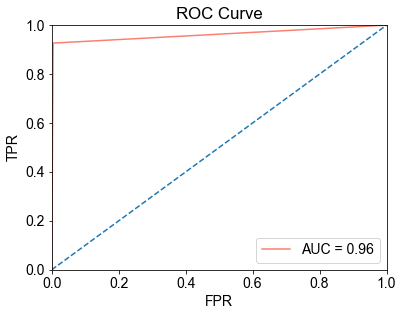

In [43]:
###ROC曲线
plot_ROC(y_test_up, y_pre_gbc, save_name='上采样Gradient Tree Boosting预测模型ROC曲线', figsize=(6,4.5))

----
不重要的内容

In [56]:
###构建分类器
# 模型调优我们采用网格搜索调优参数（grid search），通过构建参数候选集合，然后网格搜索会穷举各种参数组合，
#根据设定评定的评分机制找到最好的那一组设置。
# 构建参数组合
param_grid = {'C': [0.01,0.1, 1, 10, 100, 1000,],
                            'penalty': [ 'l1', 'l2']}

# C：Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
 
grid_search = GridSearchCV(LogisticRegression(),  param_grid, cv=5) # 确定模型LogisticRegression，和参数组合param_grid ，cv指定10折
grid_search.fit(X_train, y_train) # 使用训练集学习算法

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [57]:
##查看最优参数
print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.5f}".format(grid_search.best_score_))

# grid_search.best_estimator_ 返回模型以及他的所有参数（包含最优参数）
print("Best estimator:\n{}".format(grid_search.best_estimator_)) 

Best parameters: {'C': 10, 'penalty': 'l1'}
Best cross-validation score: 0.78298
Best estimator:
LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


In [58]:
#测试
y_pred = grid_search.predict(X_test)
print("Test set accuracy score: {:.5f}".format(accuracy_score(y_test, y_pred,)))
print(classification_report(y_test, y_pred))

Test set accuracy score: 0.78077
              precision    recall  f1-score   support

           0       0.87      0.66      0.75    153622
           1       0.73      0.90      0.80    153475

   micro avg       0.78      0.78      0.78    307097
   macro avg       0.80      0.78      0.78    307097
weighted avg       0.80      0.78      0.78    307097



In [59]:
roc_auc = roc_auc_score(y_test, y_pred)
print("Area under the ROC curve : %f" % roc_auc)


Area under the ROC curve : 0.780823


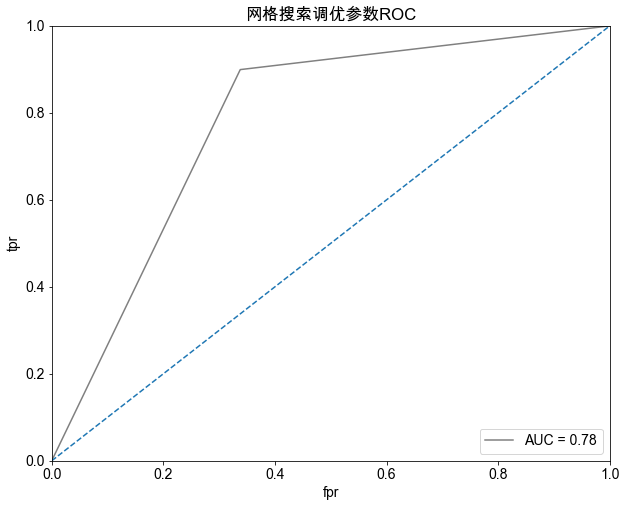

In [60]:
#ROC曲线

fpr, tpr, th = roc_curve(y_test, y_pred)
rocauc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'gray', label='AUC = %.2f' %rocauc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], '--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('网格搜索调优参数ROC')
plt.show()
plt.close()

In [61]:
###随机森林
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier()
RFC.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [63]:
rfc_y_pre = RFC.predict(X_test)

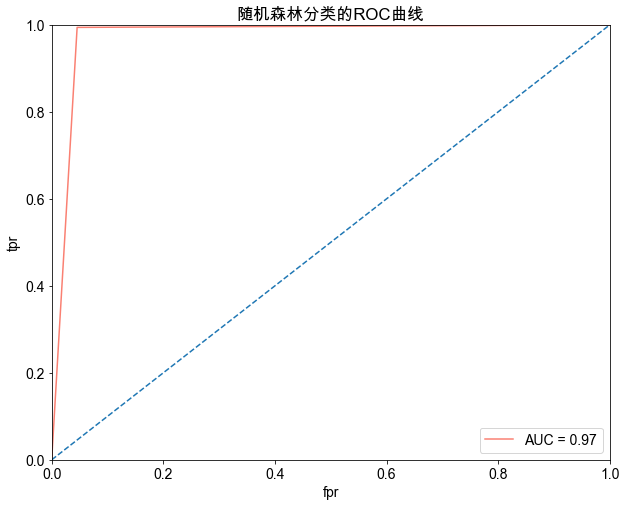

In [70]:
fpr,tpr,th=roc_curve(y_test, rfc_y_pre)
rocauc=auc(fpr,tpr)

plt.plot(fpr,tpr,'salmon',label='AUC = %.2f' %rocauc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'--', )
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('fpr')
plt.ylabel('tpr')

plt.title('随机森林分类的ROC曲线')
plt.show()
plt.close()

In [23]:
from sklearn.linear_model import LogisticRegression